# Bayesian Deep Learning

#### Nikolay Oskolkov, SciLifeLab, NBIS Long Term Support, [nikolay.oskolkov@scilifelab.se](nikolay.oskolkov@scilifelab.se)

<h3><center>Abstract</center></h3>
Here we will discuss the necessity for Bayesian Deep Learning and Probabilistic Programming and demonstrate how to practically implement a Bayesian Neural Network for real world scRNAseq problems. For this purpose, we are going to use TensorFlow, PyMC3 and Edward.

### Table of Contents:
* [Why do we need Bayesian Deep Learning?](#Why do we need Bayesian Deep Learning?)
* [Maximum Likelihood and Bayesian Fitting of Non-Linear Curve](#Maximum Likelihood and Bayesian Fitting of Non-Linear Curve)
* [What is Variational Bayes?](#What is Variational Bayes?)
* [Why Neural Networks are Good for scRNAseq?](#Why Neural Networks are Good for scRNAseq?)
* [Maximum Likelihood Classification of scRNAseq with TensorFlow](#Maximum Likelihood Classification of scRNAseq with TensorFlow)
* [Bayesian Classification of scRNAseq with PyMC3](#Bayesian Classification of scRNAseq with PyMC3)
* [How to cope with data unseen during training?](#How to cope with data unseen during training?)
* [Bonus:](#Bonus)
 * [Making your own MCMC sampler](#Making your own MCMC sampler)
 * [Fitting Non-Linear Curve with Gaussian Process](#Fitting Non-Linear Curve with Gaussian Process)

### Why do we need Bayesian Deep Learning? <a class="anchor" id="Why do we need Bayesian Deep Learning?"></a>

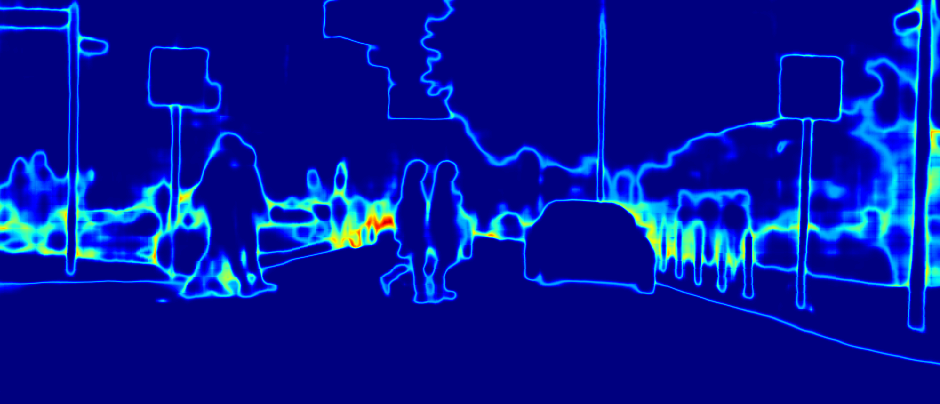

In [1]:
from IPython.display import Image
Image('/home/nikolay/WABI/Misc/SingleCell/Presentation/BayesianDeepLearning/segmentation_uncertainty.png')

Bayesian Deep Learning became extremely popular a few years ago with the development of self-driving cars, although the idea was not entirely new, already in the late 1980-th there was a literature essentially discussing implementation of Priors in the weights of Neural Networks, please watch an excellent [talk of Zoubin Ghahramani if you would like to learn more about history of Bayesian Neural Networks](https://www.youtube.com/watch?v=v1BTHd5HXYE).

"Bayesian Deep Learning" sounds a bit silly at first glance. **Why would you want to go Bayesian if you do Deep Learning?** Doesn't Deep Learning automatically imply that you works with lots of data? In contrast, Bayesian Statistics is popular in e.g. ecology, psychology primarily because of the lack of data. That is why **Priors are needed to compensate for the lack of data.** Without Priors, which play a regularization role, especially in the highly-dimensional space when n (number of observations) << p (number of features), **the math blows up** like for the case of linear regression:
<br><br>
$$
Y = \alpha + \beta X\\
\beta = \left(X^TX\right)^{-1}X^TY\\
\left(X^TX\right)^{-1} \sim \frac{1}{\rm{det}\left(X^TX\right)}\dots \rightarrow \infty, \quad\rm{n<<p}
$$

Thus, in the best case your R packages will throw errors, in the worst case you will get some answer / value which will be completely wrong because of the divergences when computing inverse matrices.

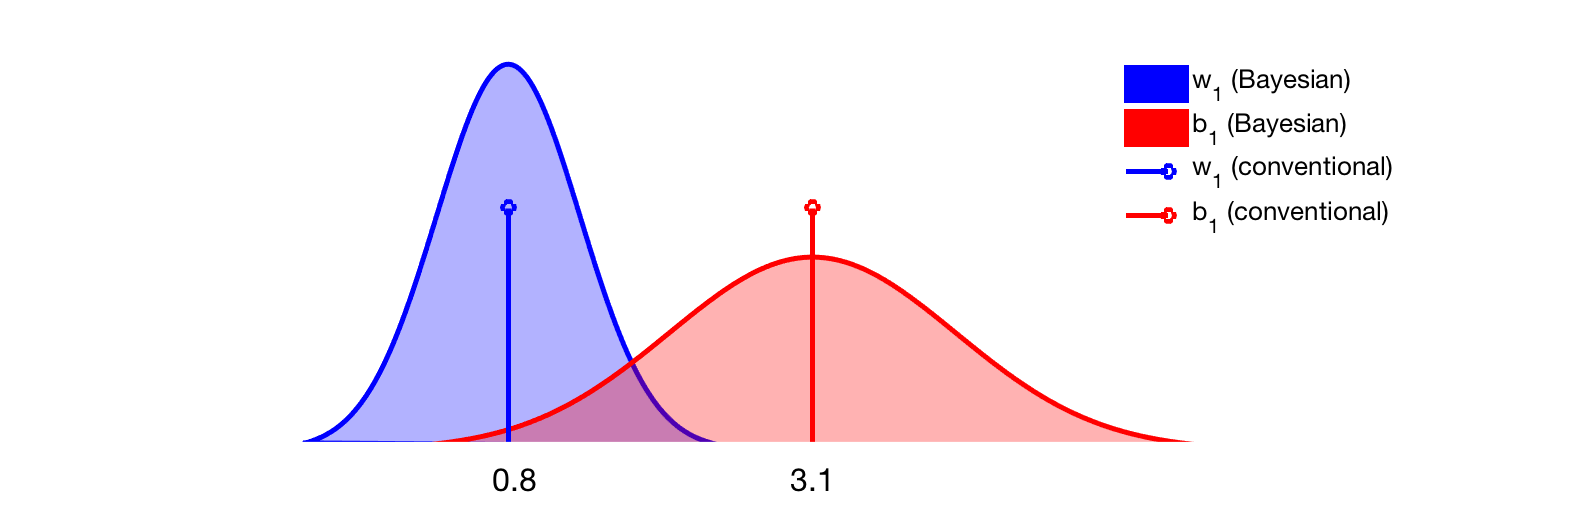

In [2]:
from IPython.display import Image
Image('/home/nikolay/WABI/Misc/SingleCell/Presentation/BayesianDeepLearning/Freq_vs_Bayes.png')

In case of Deep Learning, even if you have lots of data, the Priors besides having regularization effect and reducing overfitting can be very useful because of the **uncertainty estimates** that they deliver for free. This is very different from traditional Maximum Likelihood Neural Networks which deliver only **point estimates**, therefore being too categorical in their prediction: Yes or No answer and nothing in between.

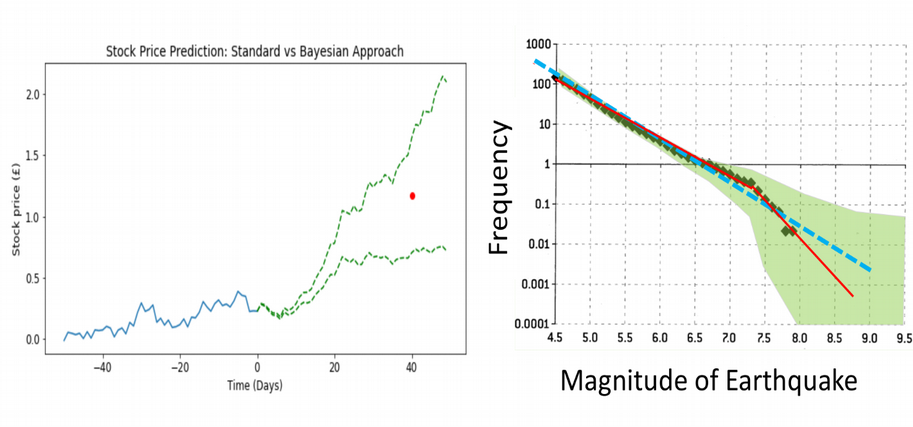

In [3]:
from IPython.display import Image
Image('/home/nikolay/WABI/Misc/SingleCell/Presentation/BayesianDeepLearning/Bayesian_vs_Frequentist_Fitting.png')

### Maximum Likelihood and Bayesian Fitting of Non-Linear Curve <a class="anchor" id="Maximum Likelihood and Bayesian Fitting of Non-Linear Curve"></a>

Now it is time to check how to implement simple Maximum Likelihood and Bayesian Neural Network and compare the outputs. Just to warm up let us start with fitting a simple non-linear 2D curve. We are going to use TensorFlow and Edward, which is a Bayesian analogue of TensorFlow, these two have very similar syntax so it will be easy to compare them. First, let us generate a toy data set with noise:

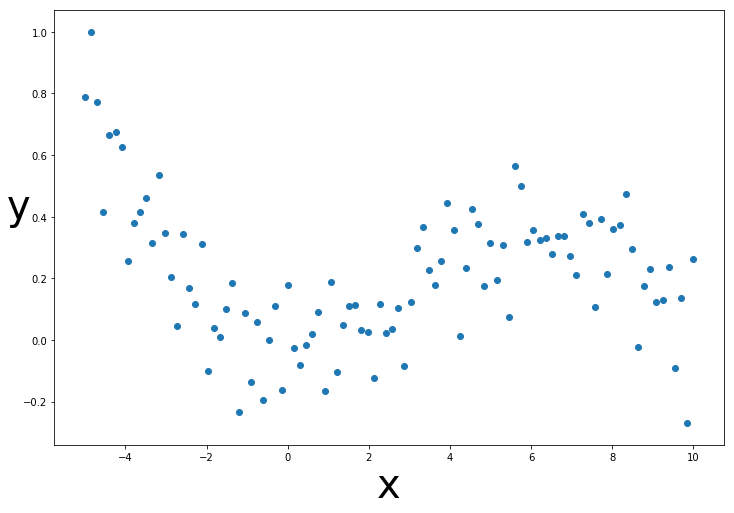

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)

N = 100
a = tf.placeholder("float")
b = tf.placeholder("float")
c = tf.placeholder("float")
d = tf.placeholder("float")
x = tf.linspace(-5.0, 10.0, num = N, name = "x")
noise = tf.random_normal(shape = [N,], mean = 0, stddev = 50.0, seed = 1)

# y = a*x^3 + b*x^2 + c*x +d 
with tf.Session() as sess:
    y = sess.run(tf.add(tf.add(tf.add(tf.add(tf.multiply(a,tf.pow(x,3)),tf.multiply(b,tf.pow(x, 2))),tf.multiply(c,x)),d),
                        noise), feed_dict= {a: -1, b: 10, c: 1, d: 1} )
    x = np.reshape(np.array(x.eval()), (N,1))
    y = np.reshape(np.array(y) / np.max(y), (N,1))

fig = plt.figure(figsize=(12, 8))
plt.scatter(x, y)
plt.xlabel("x",fontsize = 40)
plt.ylabel("y",fontsize = 40, rotation = 0)
plt.show()

This is a simple polynomial (cubic) dependence where we added some noise. We build the toy data set in TensorFlow on purpose in order to demonstrate the phylosophy of TensorFlow, i.e. how the variables are declared via placeholders and are fed with real values when the Session is initialized. Now let us fit the curve using one-hidden-layer Neural Network created in TensorFlow and check how the quality of the fit changes with the number of hidden neurons (nodes):

Fitting curve with 1 hidden neurons Maximum Likelihood Neural Network
Epoch: 0500 cost =  0.038051061
Epoch: 1000 cost =  0.031539224
************************************************************
Fitting curve with 2 hidden neurons Maximum Likelihood Neural Network
Epoch: 0500 cost =  0.020554723
Epoch: 1000 cost =  0.019995177
************************************************************
Fitting curve with 4 hidden neurons Maximum Likelihood Neural Network
Epoch: 0500 cost =  0.019057613
Epoch: 1000 cost =  0.017247500
************************************************************
Fitting curve with 16 hidden neurons Maximum Likelihood Neural Network
Epoch: 0500 cost =  0.016509237
Epoch: 1000 cost =  0.017111134
************************************************************


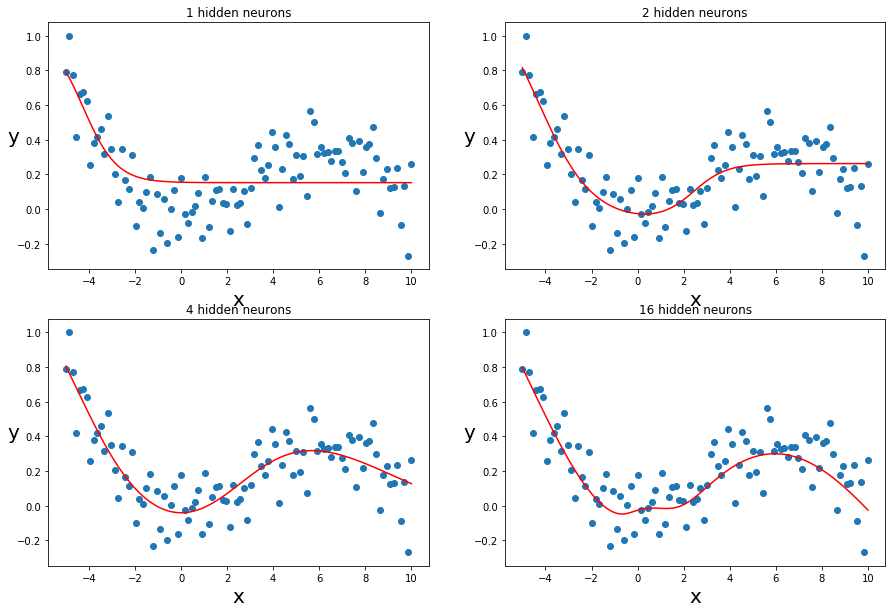

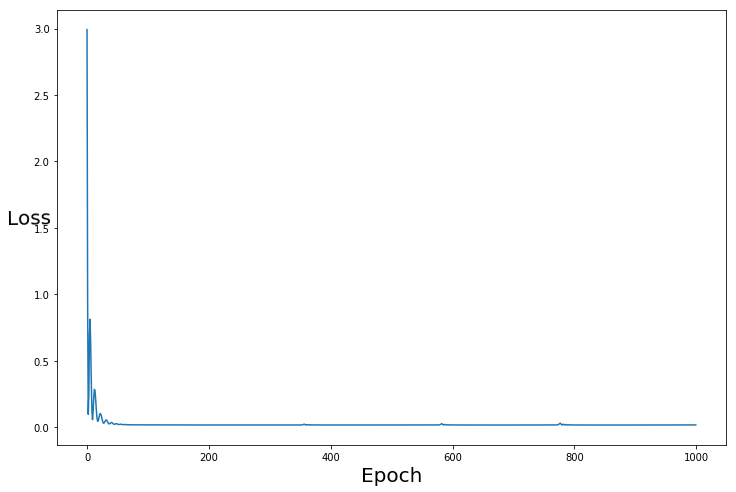

In [5]:
learning_rate = 0.1
training_epochs = 1000
display_step = 500

n_samples = x.shape[0]                 # number of samples, equal N
n_input = 1                            # number of input neurons

for my_num_hidden, my_subplot_num in zip([1, 2, 4, 16], range(1,5,1)):
    
    n_hidden = my_num_hidden           # number of hidden neurons
    print('Fitting curve with {} hidden neurons Maximum Likelihood Neural Network'.format(my_num_hidden))
    
    X = tf.placeholder("float")
    Y = tf.placeholder("float")

    weights = {'w_hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), 
               'w_output': tf.Variable(tf.random_normal([n_hidden, n_input]))}
    biases = {'b_hidden': tf.Variable(tf.random_normal([n_hidden])), 
              'b_output': tf.Variable(tf.random_normal([n_input]))}

    hidden_layer = tf.nn.sigmoid( tf.add(tf.matmul(X, weights['w_hidden']), biases['b_hidden']) )
    output_layer = tf.add(tf.matmul(hidden_layer, weights['w_output']), biases['b_output'])

    cost = tf.reduce_mean(tf.pow(output_layer - Y, 2))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    my_cost = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(training_epochs):
            c,_ = sess.run([cost, optimizer], feed_dict={X: x, Y: y})
            my_cost.append(c)
            if (epoch + 1) % display_step == 0:
                print("Epoch:", '%04d' % (epoch + 1), "cost = ", "{:.9f}".format(c))
        pred = sess.run(output_layer, feed_dict={X: x})
    plt.subplot(int("22" + str(my_subplot_num)))
    plt.scatter(x, y)
    plt.xlabel("x",fontsize = 20)
    plt.ylabel("y",fontsize = 20, rotation = 0)
    plt.plot(x, pred, c = 'r')
    plt.title('{} hidden neurons'.format(my_num_hidden))
    print('************************************************************')
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.plot(range(training_epochs), my_cost)
plt.xlabel("Epoch",fontsize = 20)
plt.ylabel("Loss",fontsize = 20, rotation = 1)
plt.show()

You can appreciate how the loss is decreasing while training the Neural Network as well as can observe how the complexity of the fitting curve is changing when adding more hidden neurons (fitting parameters). If we further increase the number of hidden neurons, we will notice that the Neural Network gets prone to overfitting when the number of hidden neurons grows, it tries to draww the fitting line through each single data point which gives a fantastic fit for that particular data set (error is zero) but horrible generalizability since the model basically starts fitting the noise (overfitting).

Now let us train a Bayesian Neural Network with identical settings using Edward, a module for building efficient Bayesian Inference. Edward is based on TensorFlow and the syntax of Edward looks very similar to the syntax of TensorFlow. However, the crucial difference here is that we put Priors on the weights and biases, as well as are using Likelihood function for the data y_train we want to fit. Edward is using so-called Variational Bayes (Variational Inference) approach to fit the Neural Network, which is drammatically faster than Markov Chain Monte Carlo. Let us first demonstrate the eresults and then explain how Variational Bayes works:

Fitting curve with 1 hidden neurons Bayesian Neural Network
10000/10000 [100%] ██████████████████████████████ Elapsed: 22s | Loss: 25781.393
************************************************************
Fitting curve with 2 hidden neurons Bayesian Neural Network
10000/10000 [100%] ██████████████████████████████ Elapsed: 23s | Loss: 9623.967
************************************************************
Fitting curve with 4 hidden neurons Bayesian Neural Network
10000/10000 [100%] ██████████████████████████████ Elapsed: 23s | Loss: 8595.666
************************************************************
Fitting curve with 16 hidden neurons Bayesian Neural Network
10000/10000 [100%] ██████████████████████████████ Elapsed: 24s | Loss: 8389.019s | Loss: 8354
************************************************************


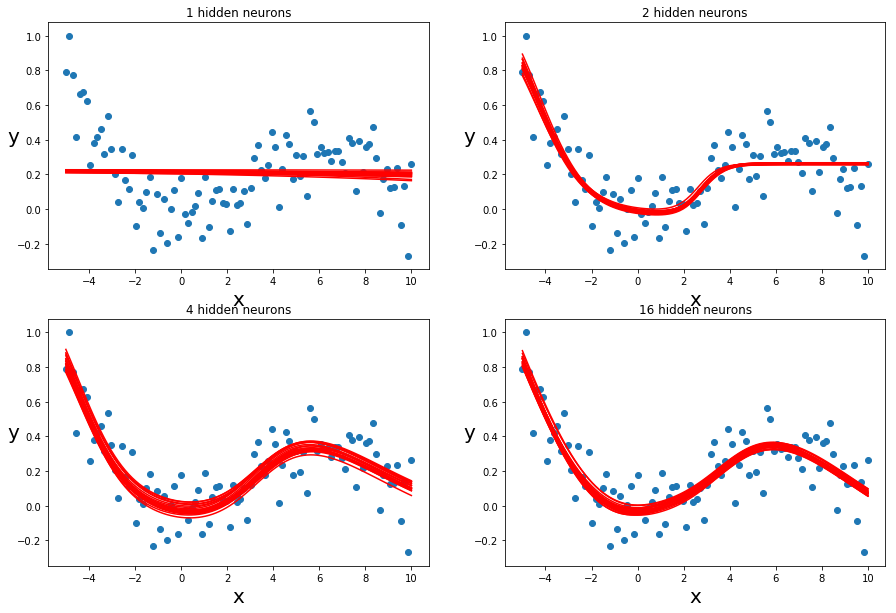

In [6]:
import edward as ed
from edward.models import Normal

n_samples = x.shape[0]                 # number of samples, equal N
n_input = 1                            # number of input neurons

for my_num_hidden, my_subplot_num in zip([1, 2, 4, 16], range(1,5,1)):
    
    n_hidden = my_num_hidden           # number of hidden neurons
    print('Fitting curve with {} hidden neurons Bayesian Neural Network'.format(my_num_hidden))

    W_0 = Normal(loc=tf.zeros([n_input, n_hidden]), scale=tf.ones([n_input, n_hidden]))
    W_1 = Normal(loc=tf.zeros([n_hidden, n_input]), scale=tf.ones([n_hidden, n_input]))
    b_0 = Normal(loc=tf.zeros(n_hidden), scale=tf.ones(n_hidden))
    b_1 = Normal(loc=tf.zeros(n_input), scale=tf.ones(n_input))

    x_train = x
    y_train = Normal(loc=tf.matmul(tf.sigmoid(tf.matmul(x_train, W_0) + b_0), W_1) + b_1, scale = 0.01)

    qW_0 = Normal(loc=tf.get_variable("qW_0/loc" + str(my_subplot_num - 1), [n_input, n_hidden]), 
                  scale=tf.nn.softplus(tf.get_variable("qW_0/scale" + str(my_subplot_num - 1), [n_input, n_hidden])))
    qW_1 = Normal(loc=tf.get_variable("qW_1/loc" + str(my_subplot_num - 1), [n_hidden, n_input]), 
                  scale=tf.nn.softplus(tf.get_variable("qW_1/scale" + str(my_subplot_num - 1), [n_hidden, n_input])))
    qb_0 = Normal(loc=tf.get_variable("qb_0/loc" + str(my_subplot_num - 1), [n_hidden]), 
                  scale=tf.nn.softplus(tf.get_variable("qb_0/scale" + str(my_subplot_num - 1), [n_hidden])))
    qb_1 = Normal(loc=tf.get_variable("qb_1/loc" + str(my_subplot_num - 1), [n_input]), 
                  scale=tf.nn.softplus(tf.get_variable("qb_1/scale" + str(my_subplot_num - 1), [n_input])))
 
    inference = ed.KLqp({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1}, data={y_train: y})
    inference.run(n_iter = 10000, n_samples = 20)
    
    def neural_network(x, W_0, W_1, b_0, b_1):
        h = tf.matmul(tf.sigmoid(tf.matmul(x, W_0) + b_0), W_1) + b_1
        return tf.reshape(h, [-1])

    mus = []
    for s in range(20):
        mus.append(neural_network(x_train, qW_0.sample(), qW_1.sample(), qb_0.sample(), qb_1.sample()))
    mus = tf.stack(mus)

    plt.subplot(int("22" + str(my_subplot_num)))
    plt.scatter(x, y)
    plt.xlabel("x",fontsize = 20)
    plt.ylabel("y",fontsize = 20, rotation = 0)
    for i in range(20):
        plt.plot(x, mus.eval()[i], c = 'r')
    plt.title('{} hidden neurons'.format(my_num_hidden))
    print('************************************************************')
plt.show()

First of all we can observe that there is not just one fitting curve but a family of possible fitting curves laying within credible intervals available from fitting the Bayesian Neural Network. The credible intervals result from sampling from the Posteriors of weights and biases which in turn results in the Posterior predictions generated by the output layer of the Bayesian Neural Network.

### What is Variational Bayes? <a class="anchor" id="What is Variational Bayes?"></a>
Now let us explain what exactly Edward was using instead of Markov Chain Monte Carlo (MCMC) sampler. Edward used an approach to computing the Posterior distribution which is called Variational Bayes or Variational Inference (VI). The idea of VI is to analytically approximate the unknown Posterior $p(\omega|D)$ with a simplier function $q_\theta(\omega|D)$, while MCMC draws samples from the unknown Posterior. Then we can just adjust parameters $\omega$ (mean, sd etc.) of the analytical approximation in order to make it as similar to the true Posterior as possible:

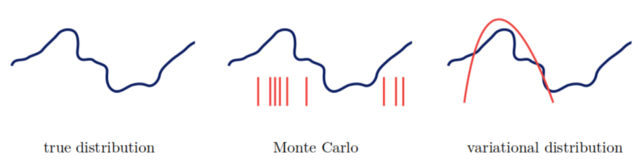

In [2]:
from IPython.display import Image
Image('/home/nikolay/WABI/Misc/SingleCell/Presentation/BayesianDeepLearning/VI.png')

Thus, the calculation of the intractable integral in the denominator of the Bayes theorem is replaced by an optimization (differentiation) problem which is much easier to solve. Technically, we need to minimize some sort of a "distance" between the true $p(\omega|D)$ and approximate $q_\theta(\omega|D)$ Posteriors, this distance can be e.g. the Kullbacl-Leibler divergence, which is a functional, i.e. a function of a function $q_\theta(\omega|D)$, therefore we need to vary (fancy word for differentiate) this functional on the family of functions $q_\theta(\omega|D)$ in order to find an optimal function $q_\theta(\omega|D)$.

$$
q_\theta(\omega|D)\approx p(\omega|D) \\
KL\left[q_\theta(\omega|D),p(\omega|D)\right]=\int q_\theta(\omega|D)\log\left(\frac{q_\theta(\omega|D)}{p(\omega|D)}\right) d\omega=\\
\int q_\theta(\omega|D)\left[\log\left(\frac{q_\theta(\omega|D)}{p(\omega|D)}\right) +\log p(D) - \log p(D) \right] d\omega=\\
\int q_\theta(\omega|D)\left[-\log\left(\frac{p(\omega|D)}{q_\theta(\omega|D)}\right) - \log p(D) + \log p(D) \right] d\omega=\\
-\int q_\theta(\omega|D)\left[\log\left(\frac{p(\omega|D)}{q_\theta(\omega|D)}\right) + \log p(D) \right] d\omega + \log p(D)= -\mathcal{L}\left[q_\theta(\omega|D)\right] + \log p(D)
$$

$$
\Rightarrow \log p(D) = const = KL\left[q_\theta(\omega|D),p(\omega|D)\right] + \mathcal{L}\left[q_\theta(\omega|D)\right]
$$

In practice, people do not minimize the KL divergence fiunctional but minimize the Evidence Lower Bound (ELBO) since KL and ELBO sum up to the constant which actually is the intractable integral in the denominator of the Bayes rule.

### Why Neural Networks are Good for scRNAseq? <a class="anchor" id="Why Neural Networks are Good for scRNAseq?"></a>
It is enough with toy examples and the dull theory of Variational Inference (VI)! Let us move to the fun part which is applying Maximum Likelohood and Bayesian Neural Networks to scRNAseq data. Why is it particularly interesting to use Machine Learning frameworks for scRNAseq? Well, because of the grotescue sample sizes, data sets with >400k and 1.3M cells are freely available! Because of the huge power (overpowered studies) **single cell data are going to dominate the analysis in Life Sciences in the nearest future**.

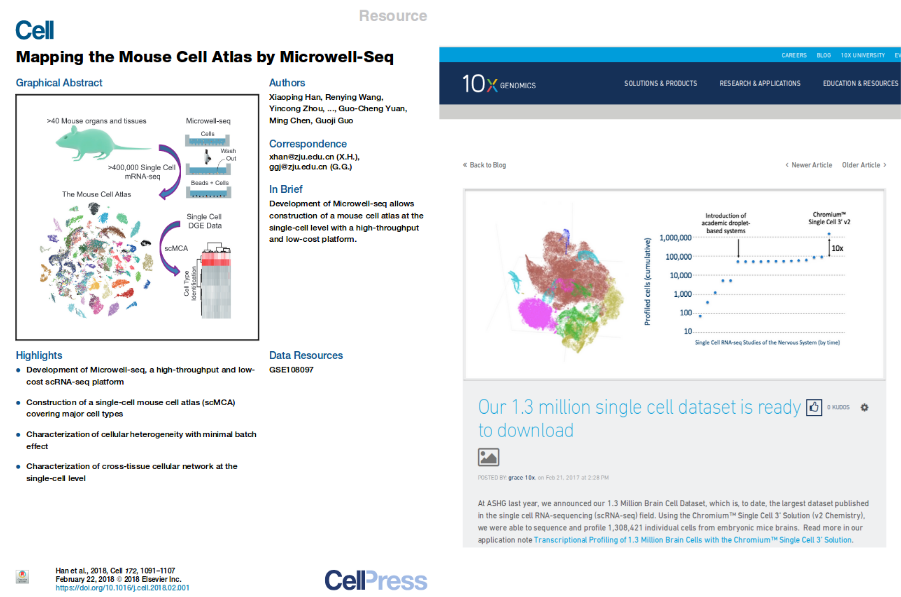

In [4]:
from IPython.display import Image
Image('/home/nikolay/WABI/Misc/SingleCell/Presentation/BayesianDeepLearning/10X_1.3M.png')

However, gigantic sample sizes pose a few chellenges which are far beyond handling Big Data and scalability. The main chellenge is how to get maximum information out of the data. Linear Algebra formalism dominating in traditional analysis and programming is not good enough any more because we have the power to catch interesting non-linear effects. This is exactly the benifit of Deep Learning, the deeper you go the more interesting non-linear effects in the data you can discover. As scRNAseq analysis is predominantly based on Dimensionality Reduction and Clustering, a natural choice of a Neural Network to use is the Deep Autoencoder:

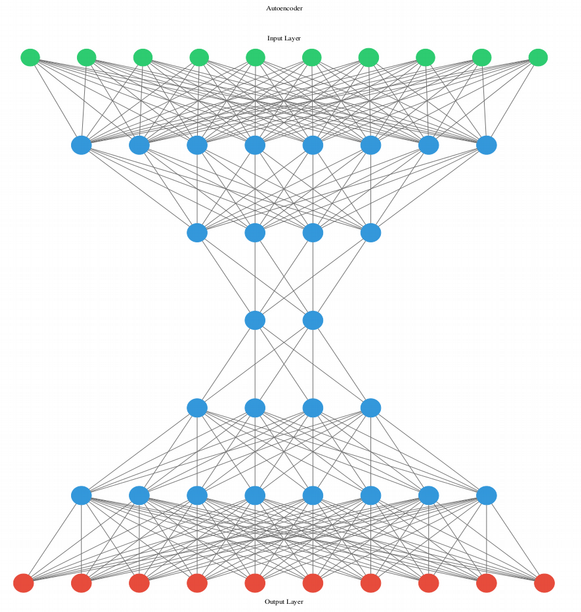

In [5]:
from IPython.display import Image
Image('/home/nikolay/WABI/Misc/SingleCell/Presentation/BayesianDeepLearning/autoencoder.png')

Here we will use the 1.3M Mouse Brain 10X genomics data set to give a flavor of how a Deep Autoencoder can be implemented in TensorFlow. A much more elaborated analysis will be presented later in the scRNAseq group discussion. TensorFlow is especially attractive for huge scRNAseq data sets because it is a very optimized and scalable language which was specifically created for working with large amounts of data.

In [7]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

# READ DATA
infile="~/WABI/Misc/SingleCell/10X_Mouse_Brain_1.3M/MouseBrain_10X_1.3M_filtered_withSeuratAnnotation_matrix_reduced.txt"
print("\n" + "You specified input file: " + infile + "\n")

expr = pd.read_csv(infile, sep = '\t', dtype = np.int16, header = None)
print("\n" + "Dimensions of input file: " + str(expr.shape) + "\n")
print("\n" + "A few first lines of input file: " + "\n")
print(expr.iloc[0:4, 0:4])
print("\n" + "Last column corresponds to cluster assignments: " + "\n")
print(expr.iloc[0:4, (expr.shape[1]-4):expr.shape[1]])

# LOG-TRANSFORM DATA
X = expr.values[:,0:(expr.shape[1]-1)]
Y = expr.values[:,expr.shape[1]-1]
print("\n" + "You have following unique cluster labels: " + "\n")
print(set(Y))
print("\n" + "Log-transforming data..." + "\n")
X = np.float16( np.log(X + 1) )


You specified input file: ~/WABI/Misc/SingleCell/10X_Mouse_Brain_1.3M/MouseBrain_10X_1.3M_filtered_withSeuratAnnotation_matrix_reduced.txt


Dimensions of input file: (1306127, 228)


A few first lines of input file: 

    0  1  2  3
0  14  5  1  3
1   2  1  1  3
2   7  6  2  6
3   8  5  1  1

Last column corresponds to cluster assignments: 

   224  225  226  227
0   40   14   19    4
1   16    7    6    9
2   13    1    8    3
3   18    6   11    5

You have following unique cluster labels: 

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}

Log-transforming data...




Performing Principal Component Analysis (PCA) ...



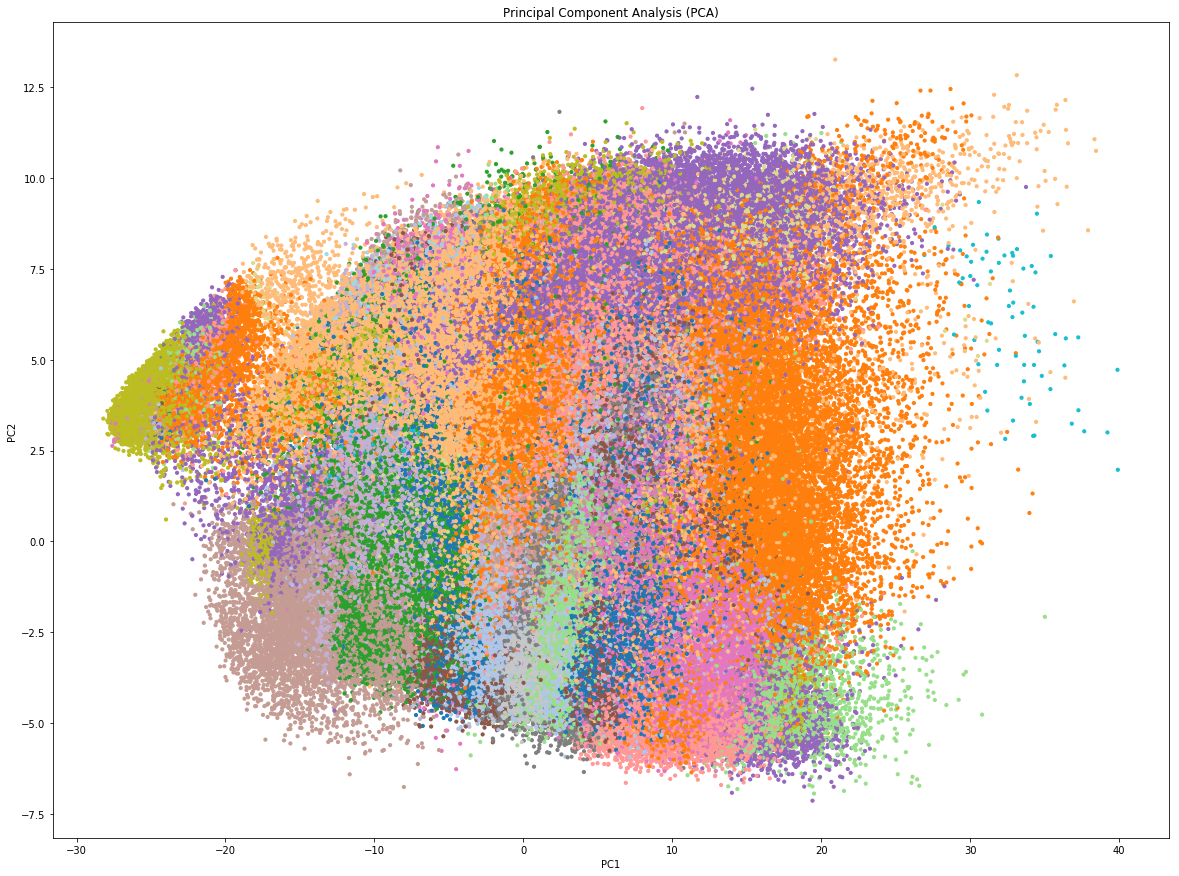

In [8]:
# REDUCE DIMENSIONS WITH PRINCIPAL COMPONENT ANALYSIS (PCA)
print("\n" + "Performing Principal Component Analysis (PCA) ..." + "\n")
n_input = 30
x_train_pca = PCA(n_components = n_input).fit_transform(X)
y_train_pca = Y
plt.figure(figsize=(20, 15))
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c = y_train_pca, cmap = 'tab20', s = 10)
plt.title('Principal Component Analysis (PCA)')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

As we can see the PCA looks messy, linear dimensionality reduction is clearly not good enough for capturing distinct scRNAseq clusters of Mouse Brain cells. We need a non-linear scalable dimenionality reduction such as a Deep Autoencoder. Potentially tSNE is the greatest choice for scRNAseq data visualization, however it has problems with scalability which Autoencoders do not have. Alternatively one can program tSNE in TensorFlow which should be the fastest implementation possible to date.

In [9]:
import keras
import numpy as np
import pandas as pd
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.optimizers import Adam
from sklearn.decomposition import PCA
from keras.models import Sequential, Model

import warnings
warnings.filterwarnings("ignore")

# REDUCE DIMENSIONS WITH AUTOENCODER
model = Sequential()
model.add(Dense(100,      activation='elu',    kernel_initializer='he_uniform', input_shape=(n_input,)))
model.add(Dense(20,       activation='elu',    kernel_initializer='he_uniform'))
model.add(Dense(2,        activation='linear', kernel_initializer='he_uniform', name="bottleneck"))
model.add(Dense(20,       activation='elu',    kernel_initializer='he_uniform'))
model.add(Dense(100,      activation='elu',    kernel_initializer='he_uniform'))
model.add(Dense(n_input,  activation='sigmoid'))
model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = 0.001))
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_4 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_5 (Dense)              (None, 30)                3030      
Total params: 10,352
Trainable params: 10,352
Non-trainable params: 0
_________________________________________________________________



Constructing Autoencoder Model ...


Start Training Autoencoder ...

Epoch: 0010 cost =  2.003934145
Epoch: 0020 cost =  1.921739697
Epoch: 0030 cost =  1.909895301
Epoch: 0040 cost =  1.898036718
Epoch: 0050 cost =  1.875674725
Epoch: 0060 cost =  1.864142299
Epoch: 0070 cost =  1.861230493
Epoch: 0080 cost =  1.854442477
Epoch: 0090 cost =  1.847046971
Epoch: 0100 cost =  1.837089539


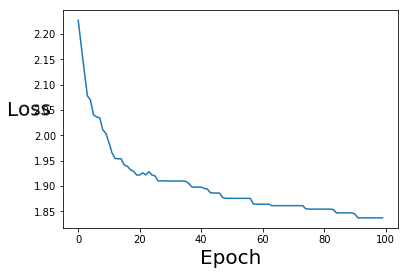

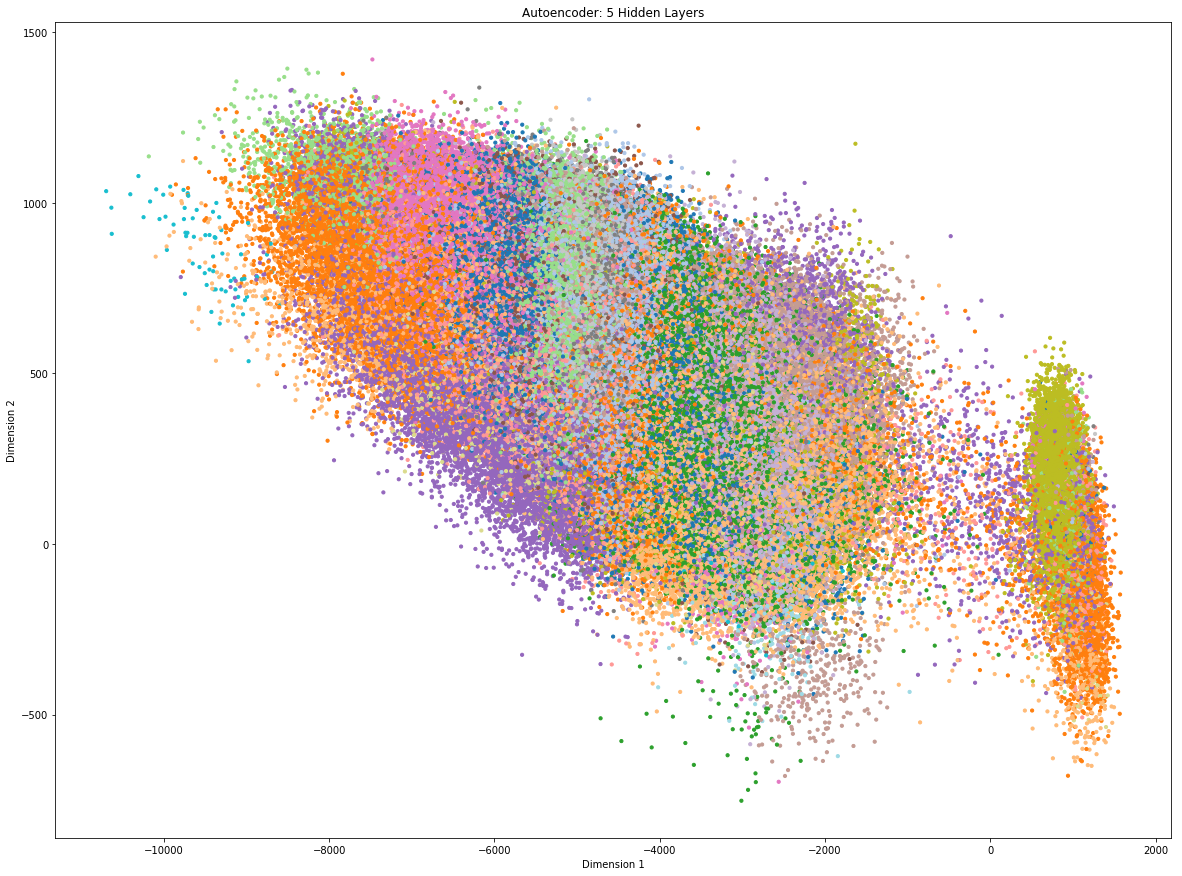

In [10]:
# DEFINE HYPERPARAMETERS
learning_rate   = 0.01
training_epochs = 100
display_step    = 10
num_hidden_1    = 100            # 1st hidden layer num features
num_hidden_2    = 20             # 2nd hidden layer num features
num_bottleneck  = 2              # bottleneck num features
num_input       = X.shape[1]     # scRANAseq data input (number of features / genes)

# TENSORFLOW GRAPH INPUT
x = tf.placeholder("float")
y = tf.placeholder("float")

weights = {
    'encoder_h1':  tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2':  tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'bottleneck':  tf.Variable(tf.random_normal([num_hidden_2, num_bottleneck])),
    'decoder_h1':  tf.Variable(tf.random_normal([num_bottleneck, num_hidden_2])),
    'decoder_h2':  tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_out': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1':  tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2':  tf.Variable(tf.random_normal([num_hidden_2])),
    'bottleneck':  tf.Variable(tf.random_normal([num_bottleneck])),
    'decoder_b1':  tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b2':  tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_out': tf.Variable(tf.random_normal([num_input])),
}

# CONSTRUCT AUTOENCODER MODEL
print("\n" + "Constructing Autoencoder Model ..." + "\n")
def encoder(x):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    bottleneck = tf.add(tf.matmul(layer_2, weights['bottleneck']), biases['bottleneck'])
    return bottleneck

def decoder(x):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    layer_out = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_out']), biases['decoder_out']))
    return layer_out
    
encoder_op = encoder(x)
decoder_op = decoder(encoder_op)
y_pred = decoder_op
y_true = x
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)    
    
# START TRAINING AUTOENCODER
print("\n" + "Start Training Autoencoder ..." + "\n")
my_cost = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs):
        c,_ = sess.run([cost, optimizer], feed_dict={x: X, y: Y})
        my_cost.append(c)
        if (epoch + 1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost = ", "{:.9f}".format(c))
    pred = sess.run(encoder(x), feed_dict={x: X})
            
plt.plot(range(training_epochs), my_cost)
plt.xlabel("Epoch",fontsize = 20)
plt.ylabel("Loss",fontsize = 20, rotation = 1)
plt.show()

# VISUALIZE AUTOENCODER BOTTLENECK
plt.figure(figsize=(20, 15))
plt.scatter(pred[:,0], pred[:,1], c = Y, s = 10, cmap = 'tab20')
plt.title('Autoencoder: 5 Hidden Layers')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### Maximum Likelihood Classification of scRNAseq with TensorFlow <a class="anchor" id="Maximum Likelihood Classification of scRNAseq with TensorFlow"></a>
Here we are going to show how to use TensorFlow to build a nonlinear classifier for a real scRNAseq data det for Cancer-Associated Fibroblasts (CAFs) from Kristian Pietras project, Lund University. We will start with loading modules, reading and transforming the data. Please note that the last column corresponds to cluster assignment of the cells:

In [7]:
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# READ DATA
expr = pd.read_csv('/home/nikolay/WABI/K_Pietras/Manifold_Learning/bartoschek_filtered_expr_rpkm.txt', sep='\t')
print("\n" + "Dimensions of input file: " + str(expr.shape) + ", that means you have " + str(expr.shape[0]) + 
      " cells and " + str(expr.shape[1] - 1) + " genes remained after filtering" + "\n")
print("\n" + "A few first lines of input file: " + "\n")
print(expr.iloc[0:4, 0:4])
print("\n" + "Last column corresponds to cluster assignments: " + "\n")
print(expr.iloc[0:4, (expr.shape[1]-4):expr.shape[1]])

# LOG-TRANSFORM DATA
X = expr.values[:,0:(expr.shape[1]-1)]
Y = expr.values[:,expr.shape[1]-1]
print("\n" + "A few cluster labels: " + "\n")
print(Y[0:8])
print("\n" + "Number of unique clusters: " + str(len(set(Y))) + "\n")
print("\n" + "You have following unique cluster labels: " + "\n")
print(set(Y))
print("\n" + "Log-transforming data..." + "\n")
X = np.log(X + 1)


Dimensions of input file: (716, 558), that means you have 716 cells and 557 genes remained after filtering


A few first lines of input file: 

                1110020A21Rik  1110046J04Rik  1190002F15Rik  1500015A07Rik
SS2_15_0048_A3            0.0            0.0            0.0            0.0
SS2_15_0048_A6            0.0            0.0            0.0            0.0
SS2_15_0048_A5            0.0            0.0            0.0            0.0
SS2_15_0048_A4            0.0            0.0            0.0            0.0

Last column corresponds to cluster assignments: 

                Zfp652os  Zfp81  Zfp944  cluster
SS2_15_0048_A3       0.0    0.0     0.0        1
SS2_15_0048_A6       0.0    0.0     0.0        1
SS2_15_0048_A5       0.0    0.0     0.0        1
SS2_15_0048_A4       0.0    0.0     0.0        2

A few cluster labels: 

[ 1.  1.  1.  2.  1.  2.  2.  4.]

Number of unique clusters: 4


You have following unique cluster labels: 

{1.0, 2.0, 3.0, 4.0}

Log-transforming data...



Next, we will perform tSNE dimensionality reduction and select only first two tSNE components to train our Neural Network classifier on, so only two dimensions will be used in the further analysis:

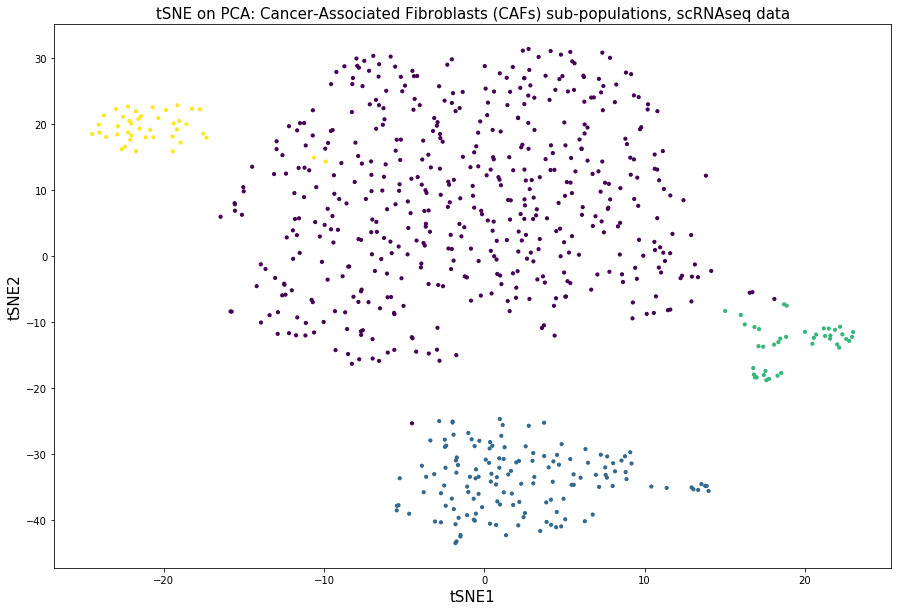

In [9]:
X_reduced = PCA(n_components = 30).fit_transform(X)
model = TSNE(learning_rate = 10, n_components = 2, random_state = 123, perplexity = 30)
tsne = model.fit_transform(X_reduced)
plt.scatter(tsne[:, 0], tsne[:, 1], c = Y, cmap = 'viridis', s = 10)
plt.title('tSNE on PCA: Cancer-Associated Fibroblasts (CAFs) sub-populations, scRNAseq data', fontsize = 15)
plt.xlabel("tSNE1", fontsize = 15)
plt.ylabel("tSNE2", fontsize = 15)
plt.show()

Now we will split the 4-classes data set into train and test subsets while keeping fractions of each class constant, and convert the labels for clusters into one-hot-encoded format: 

In [10]:
X_tsne = tsne[:, 0:2]
Y_tsne = Y

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_tsne, Y_tsne, test_size = 0.4, stratify = None, random_state = 12)

from sklearn.preprocessing import OneHotEncoder
Y_train_original = Y_train
Y_train = np.array( OneHotEncoder().fit_transform(Y_train.reshape(-1, 1)).todense() )
Y_test_original = Y_test
Y_test = np.array( OneHotEncoder().fit_transform(Y_test.reshape(-1, 1)).todense() )
Y_train

array([[ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.]])

Before building the model in TensorFlow, the last thing we need to do is to define a grid for further plotting the decision boundaries of the classifier. The grid is based on X_test, we place equidistantly 100 points from minimal X_test to maximal X_test values, remember those are the tSNE coordinates. Next, we will build a two-dimensional numpy array for each of the 100 x 100 points of the grid, we will execute the classifier at each of those grid points and assign cluster label (with certain softmax probability) to each of the grid points:

In [11]:
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
print(xx.ravel())
print(yy.ravel())
my_grid_values = np.c_[xx.ravel(), yy.ravel()]
my_grid_values

[-25.45372772 -24.96335497 -24.47298222 ...,  22.60280209  23.09317484
  23.58354759]
[-42.60585785 -42.60585785 -42.60585785 ...,  32.0933876   32.0933876
  32.0933876 ]


array([[-25.45372772, -42.60585785],
       [-24.96335497, -42.60585785],
       [-24.47298222, -42.60585785],
       ..., 
       [ 22.60280209,  32.0933876 ],
       [ 23.09317484,  32.0933876 ],
       [ 23.58354759,  32.0933876 ]])

Finally, we will build our model in TensorFlow, it is simple one-hidden-layer model, so far we are not building deep neural networks. We will use Adam optimizer to minimize softmax cross entropy since this is a multi-class classification problem. The output layer generates predictions, there are two prediction variables used: 1) pred is for evaluating the model using the true labels from the test data set, 2) pred_my_grid is for assigning a class label to each of the 100 x 100 grid points, this will allow us to visualize decision boundaries later.

Epoch: 1000 cost =  0.008452263
Epoch: 2000 cost =  0.002392855
Epoch: 3000 cost =  0.001046736
Epoch: 4000 cost =  0.000534425
Epoch: 5000 cost =  0.000292803
Epoch: 6000 cost =  0.000166500
Epoch: 7000 cost =  0.000096564
Epoch: 8000 cost =  0.000055211
Epoch: 9000 cost =  0.000032715
Epoch: 10000 cost =  0.000019441


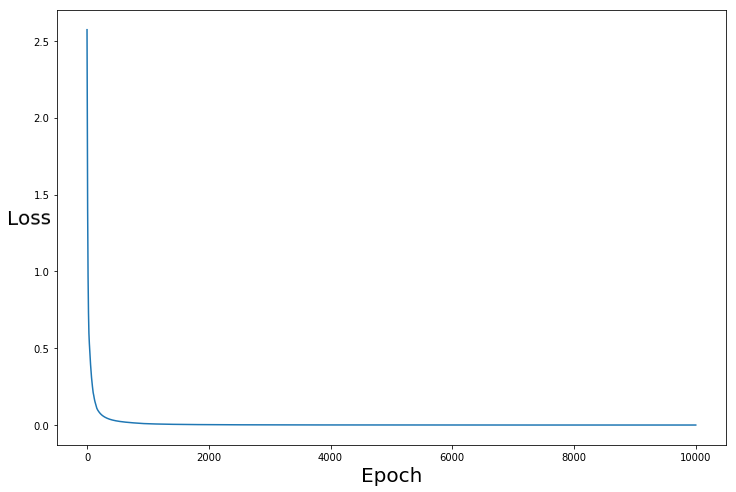

In [12]:
import tensorflow as tf

learning_rate = 0.01
training_epochs = 10000
display_step = 1000

n_samples = X_train.shape[0]
n_classes = len(set(Y))
n_input = X_train.shape[1]
n_hidden = 16

X = tf.placeholder("float")
Y = tf.placeholder("float")

weights = {'w_hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), 
           'w_output': tf.Variable(tf.random_normal([n_hidden, n_classes]))}
biases = {'b_hidden': tf.Variable(tf.random_normal([n_hidden])), 
          'b_output': tf.Variable(tf.random_normal([n_classes]))}

hidden_layer = tf.nn.sigmoid( tf.add( tf.matmul(X, weights['w_hidden']), biases['b_hidden'] ) )
output_layer = tf.add( tf.matmul( hidden_layer, weights['w_output'] ), biases['b_output'] )

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = output_layer, labels = Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

my_cost = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs):
        c,_ = sess.run([cost, optimizer], feed_dict={X: X_train, Y: Y_train})
        my_cost.append(c)
        if (epoch + 1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost = ", "{:.9f}".format(c))
    #EVALUATE MODEL
    pred_my_grid = sess.run( tf.nn.softmax(output_layer), feed_dict={X: my_grid_values} )
    pred = sess.run( tf.nn.softmax(output_layer), feed_dict={X: X_test} )
    check_prediction = sess.run( tf.equal(tf.argmax(pred, 1), tf.argmax(Y_test, 1)) )
    accuracy = sess.run( tf.reduce_mean( tf.cast(check_prediction, "float") ) )
fig = plt.figure(figsize=(12, 8))
plt.plot(range(training_epochs), my_cost)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Loss", fontsize = 20, rotation = 1)
plt.show()

The loss curve reachs its plateau which is a good indication of convergence of our model. Let us now display evaluation results for the test data set. We will build a data frame with correct class labels, predicted labesl as well as a simple True / False check of whether predicted label agrees with the true label. Finally, we display the accuracy value and the confusion matrix where we can see samples for which classes were misclassified.

In [13]:
pred_output = pd.DataFrame({'True': np.array([np.argmax(i) for i in Y_test]),
                          'Pred': np.array([np.argmax(i) for i in pred]),
                           'Check': check_prediction})
print(pred_output.iloc[0:10,0:3])
print("Accuracy:", accuracy)

   True  Pred  Check
0     0     0   True
1     1     1   True
2     1     1   True
3     0     0   True
4     0     0   True
5     0     0   True
6     0     0   True
7     0     0   True
8     0     0   True
9     0     0   True
Accuracy: 0.986063


             precision    recall  f1-score   support

          0       0.98      1.00      0.99       191
          1       1.00      1.00      1.00        57
          2       1.00      0.88      0.94        17
          3       1.00      0.91      0.95        22

avg / total       0.99      0.99      0.99       287



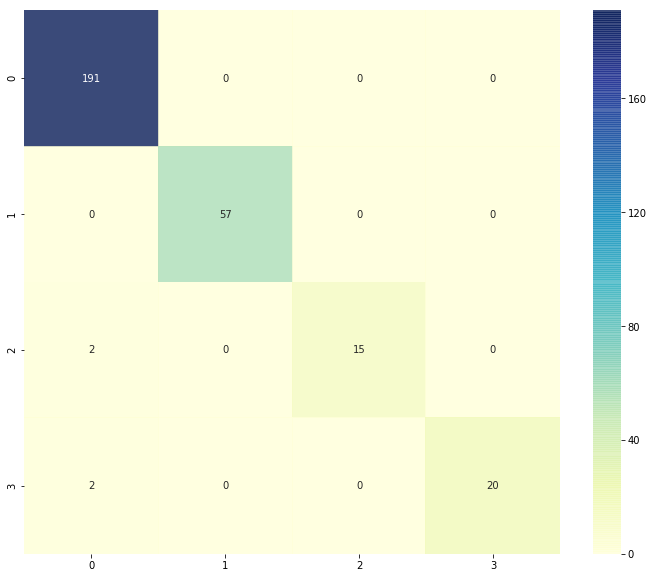

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print(classification_report([np.argmax(i) for i in Y_test], 
                                          [np.argmax(i) for i in np.array([np.round(i) for i in pred])]))
fig = plt.figure(figsize=(12, 10))
sns.heatmap(pd.DataFrame(confusion_matrix([np.argmax(i) for i in Y_test], 
                                          [np.argmax(i) for i in np.array([np.round(i) for i in pred])] )),
            annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)
plt.show()

Now we are going to do something interesting, we are going to draw the decision boundaries for the classifier. We are going to display the probability of assigning each point of the 100 x 100 grid to a certain class (cell sub-population). In this way we could understand what would be a probability of assigning each sample / cell from the test data set to each class. Actually, we have the softmax probability for each class for each sample information stored in the pred_my_grid variable:

In [16]:
print(pred_my_grid)

[[  9.99986649e-01   1.31544120e-05   2.06346868e-07   2.70533329e-09]
 [  9.99978304e-01   2.13577114e-05   3.43683837e-07   3.20276117e-09]
 [  9.99962091e-01   3.73638904e-05   6.19005050e-07   3.89155907e-09]
 ..., 
 [  1.00000000e+00   2.72678697e-08   1.09942033e-09   4.12492737e-17]
 [  1.00000000e+00   2.72674541e-08   1.09940979e-09   4.12445521e-17]
 [  1.00000000e+00   2.72671414e-08   1.09940146e-09   4.12407769e-17]]


Thus we can contruct a data frame where for each sample we have information to which class it is predicted to belong to and the softmax probability of such prediction:

In [17]:
pd.DataFrame({'Class': np.array([np.argmax(i) for i in pred_my_grid]), 
              'Prob': np.array([np.max(i) for i in pred_my_grid])}).sample(frac=1).iloc[0:10, 0:2]

Class      Prob
775        1  0.999997
1142       0  0.879425
6530       0  1.000000
3305       0  0.809024
9560       0  1.000000
2860       0  0.999998
655        1  0.999997
1932       0  0.999999
10109      0  0.972402
4501       0  0.999948

Now we will construct a new Z_prob variable which will contain the probability of predicted class. Finally, we will display the probability heatmap on the tSNE plot:

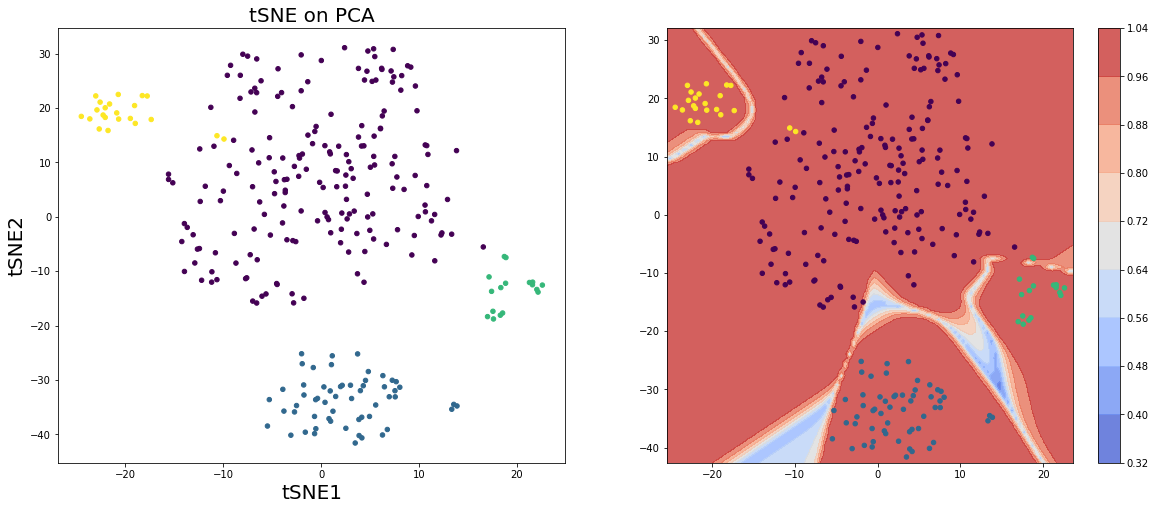

In [18]:
Z_prob = np.array([np.max(i) for i in pred_my_grid])
Z_prob = Z_prob.reshape(xx.shape)
Z_prob

fig = plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.title('tSNE on PCA', fontsize = 20)
plt.xlabel("tSNE1", fontsize = 20)
plt.ylabel("tSNE2", fontsize = 20)

plt.subplot(122)
plt.contourf(xx, yy, Z_prob, cmap = plt.cm.coolwarm, alpha = 0.8)
plt.colorbar()
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

Plotting the probability for the most likely class of cells draws basically decision boundaries between the cell sub-populations. The blueish areas depict regions where probability of assignment to a most likely class approaches 50%. Please notice that a yellow point is included into the crowd of purple points having a red are as a background, this implies that the probability of assigning that yellow cell to the class of purple cells is almost 100%. This is because we were using a Maximum Likelihood Neural Network which lacks uncertainty information about probabilities of assignment to a cluster.

### Bayesian Classification of scRNAseq with PyMC3 <a class="anchor" id="Bayesian Classification of scRNAseq with PyMC3"></a>

Now we are going to build a Bayesian Neural Network using PyMC3 Python module. The idea behind Bayesian Neural Networks is that weights and biases are not point estimates but they have Prior probabilities. The strength of using PyMC3 is that we can use both MCMC and Variational Inference (VI) approaches, in contrast to Edward which is purely VI-based tool, while it is quite questionable whether VI can completely replace proper samplers for complex Posteriors. Another benifit of PyMC3 is that one can create any model, including Neural Network, and simply run a sampler on the model in the Bayesian fashion. Thus we will start with loading modules, PyMC3 is Theano based so it is especially impoirtant to load theano and theano.tensor, the latter contains the softmax activation function to be used for the output layer:

In [19]:
import theano
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')

Next we are going to contruct a model whcih is a Bayesian Neural Network with one hidden layer and n_hidden neurons. We will assign Normal Priors to weights and biases and initialize them with random values. Within the model we define also the likelihood which is a Categorical distribution since we are dealing with a scRNAseq multi-class (4 classes) classification problem.

In [20]:
def build_bayesian_neural_network(X, Y):
    
    n_samples = X.get_value().shape[0]
    n_classes = Y.get_value().shape[1]
    n_input = X.get_value().shape[1]
    n_hidden = 16
    
    with pm.Model() as model:
        
        # Priors for unknown model parameters
        w_hidden = pm.Normal( 'w_hidden', mu = 0, sd = 1, shape = (n_input, n_hidden), 
                             testval = np.random.randn(n_input, n_hidden) )
        w_output = pm.Normal( 'w_output', mu = 0, sd = 1, shape = (n_hidden, n_classes), 
                             testval = np.random.randn(n_hidden, n_classes) )
        b_hidden = pm.Normal( 'b_hidden', mu = 0, sd = 1, shape = (n_hidden), 
                             testval = np.random.randn(n_hidden) )
        b_output = pm.Normal( 'b_output', mu = 0, sd = 1, shape = (n_classes), 
                             testval = np.random.randn(n_classes) )
        
        # Expected value of outcome
        hidden_layer = pm.math.tanh( pm.math.dot(X.get_value(), w_hidden) + b_hidden )
        output_layer = pm.Deterministic('output_layer', tt.nnet.softmax(pm.math.dot(hidden_layer, w_output) + b_output))
        
        # Likelihood (sampling distribution) of observations
        likelihood = pm.Categorical('likelihood', output_layer, observed = np.where(Y.get_value())[1])
    
    return model

Please note that putting Priors on the weights and biases we let the model know that those parameters have uncertainties, therefore the MCMC sampler will build Posterior distributions for them. However, we are also interested in knowing the Posterior distribution for the prediction of the output layer (which is a combination of input, weights and biases), i.e. not only softmax probabilities for each class but also the confidence intervals for those probabilities. PyMC3 will not track those Posterior distributions by default because we have not explicitly assigned Priors to the output layer. In PyMC3, pm.Deterministic is a way to tell the MCMC sampler to follow that variable (output layer in our case) as well and build a Posterior for that variable.

Now we are going to define a function whcih draws samples from the Posteriors of the parameters of the Bayesian Neural Network using one of the Hamiltonian Monte Carlo (a much faster sampler compared to e.g. Metropolis when derivatives of the parameters can be calculated) algorithms called NUTS.

In [21]:
def train_bayesian_neural_network(model):
    
    with model:
        draws = 1000
        start = pm.find_MAP(maxeval = 10000)
        step = pm.NUTS()
        trace = pm.sample(draws = draws, step = step, start = start)
    
    return trace

Here we used pre-calculated MAP approximation for initiating parameters of the Bayesian Neural Network. You can find information about any PyMC3 method, including the MAP approximation through the handy help available in PyMC3:

In [22]:
help(pm.find_MAP)

Help on function find_MAP in module pymc3.tuning.starting:

find_MAP(start=None, vars=None, method='L-BFGS-B', return_raw=False, include_transformed=True, progressbar=True, maxeval=5000, model=None, *args, **kwargs)
    Finds the local maximum a posteriori point given a model.
    
    Parameters
    ----------
    start : `dict` of parameter values (Defaults to `model.test_point`)
    vars : list
        List of variables to optimize and set to optimum (Defaults to all continuous).
    method : string or callable
        Optimization algorithm (Defaults to 'L-BFGS-B' unless
        discrete variables are specified in `vars`, then
        `Powell` which will perform better).  For instructions on use of a callable,
        refer to SciPy's documentation of `optimize.minimize`.
    return_raw : bool
        Whether to return the full output of scipy.optimize.minimize (Defaults to `False`)
    include_transformed : bool
        Flag for reporting automatically transformed variables in add

Now let us start training the Bayesian Neural Network by using the MCMC sampler for drawing samples from the Posteriors with NUTS sampler by providing X_train and Y_train data set. Here we use the following trick: we crate shared theano variables and assign X_train and Y_train to them, those variables can be later reset to X_test and Y_test.

In [23]:
%%time
X = theano.shared(X_train)
Y = theano.shared(Y_train)
model = build_bayesian_neural_network(X, Y)
trace = train_bayesian_neural_network(model)

logp = -132.05, ||grad|| = 0.11195: 100%|██████████| 960/960 [00:00<00:00, 1066.45it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_output, b_hidden, w_output, w_hidden]
Sampling 2 chains: 100%|██████████| 3000/3000 [07:02<00:00,  5.05draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 9.92 s, sys: 948 ms, total: 10.9 s
Wall time: 7min 12s


The MCMC NUTS sampler has built Posteriors for all model parameters including the values on the output layer. The variable trace['output_layer'] is a tensor (3-dimensional array), where first dimension is 2000 samples drawn from the Posterior of the output layer, this number comes from 2 chains x 1000 samples drawn for each chain. Second dimension is the number of samples in the train data set. The third dimension is probabilities of each of the 4 classes. Thus for each cell on the train tSNE plot (429 cells) we have 4 probabilities of assignment to one of the 4 clusters. These probabilities of assignments were drawn 2000 times from from the Posteriors of the output layer. 

In [24]:
trace['output_layer'].shape

(2000, 429, 4)

In [25]:
pm.summary(trace).iloc[0:10,0:10]

mean        sd  mc_error   hpd_2.5  hpd_97.5       n_eff  \
w_hidden__0_0 -0.015414  0.939245  0.044529 -2.070447  1.698538  371.597858   
w_hidden__0_1 -0.090787  0.857970  0.038591 -2.008188  1.653057  403.683598   
w_hidden__0_2  0.003815  0.852829  0.036637 -1.722482  1.851492  433.468880   
w_hidden__0_3  0.037047  0.906153  0.041691 -1.823134  1.921469  321.343856   
w_hidden__0_4  0.015246  0.923550  0.039210 -1.735902  1.998157  479.551748   
w_hidden__0_5  0.007804  0.918240  0.037086 -1.923721  1.823528  491.177631   
w_hidden__0_6  0.038632  0.876240  0.040853 -1.819199  1.803538  326.185034   
w_hidden__0_7  0.100768  0.903541  0.038534 -1.643122  1.885836  510.310287   
w_hidden__0_8  0.005218  0.922420  0.045076 -1.652594  2.002867  299.048638   
w_hidden__0_9  0.038853  0.890918  0.040067 -1.763900  2.013395  387.270740   

                   Rhat  
w_hidden__0_0  1.000765  
w_hidden__0_1  0.999688  
w_hidden__0_2  1.000507  
w_hidden__0_3  1.002728  
w_hidden__0_4  1.000545  
w_hidden__0_5  1.005609  
w_hidden__0_6  1.018777  
w_hidden__0_7  1.003803  
w_hidden__0_8  1.009655  
w_hidden__0_9  1.004632

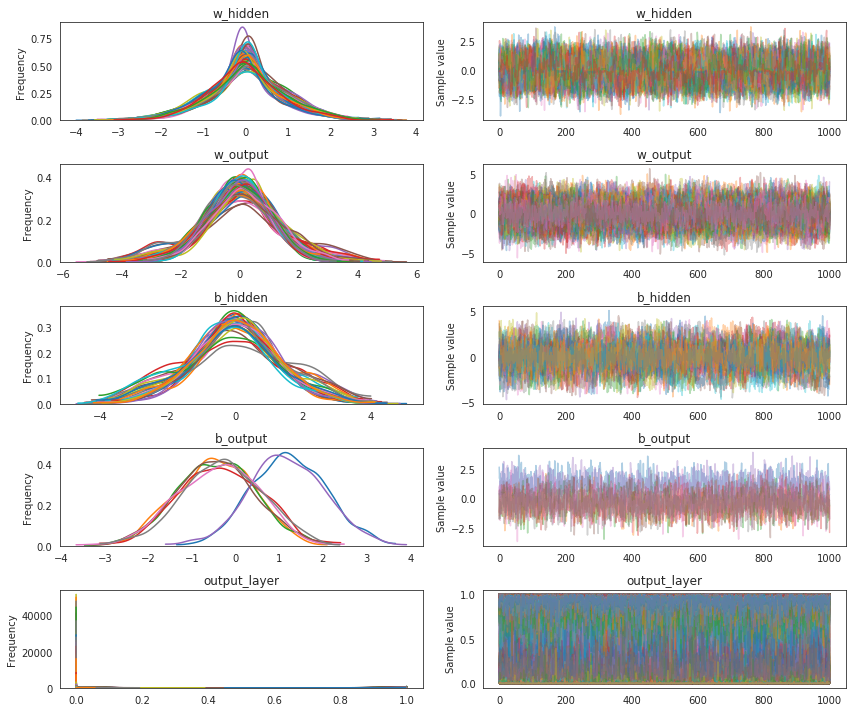

In [26]:
_ = pm.traceplot(trace)
plt.show()

Let us average ove the 2000 samples and create 4 probabilities of assignment to one of the 4 clusters for each of 429 cells, those are predicted labels of the model, we compare them with the true T_train one-hot encoded labels:

In [27]:
print(trace['output_layer'].mean(axis=0))

[[  5.31702649e-02   4.69494944e-02   8.99672702e-01   2.07538806e-04]
 [  9.96618420e-01   1.65660721e-05   1.19211175e-03   2.17290173e-03]
 [  9.97838098e-01   7.81188320e-06   1.03082976e-03   1.12326027e-03]
 ..., 
 [  9.99074209e-01   8.16448962e-06   4.25534695e-04   4.92091468e-04]
 [  7.56843593e-02   4.68146528e-03   1.24824794e-04   9.19509351e-01]
 [  1.20636046e-02   9.81622808e-01   4.67338586e-03   1.64020127e-03]]


In [28]:
Y_train

array([[ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.]])

The predictions given y the output layer seem to correctly predict the true class labels, and the accuracy of such predictions is of course very high due to evaluating the model on the training data set, this is not what we want since this is not a correct model evaluation:

In [29]:
print('Accuracy={}%'.format((np.where(Y_train)[1]==[np.argmax(i)for i in trace['output_layer'].mean(axis=0)]).mean()*100))

Accuracy=99.76689976689977%


In order to get a correct model evaluation, let us critisize the model by applying so-called a Posterior Predictive Check (PPC) procedure on the hold-out test dat set. PPC randomly selects 500 samples from the Posteriors of the parameters of the trained Bayesian Neural Network and builds a Normal distribution centered around each of the 500 drawn values. Then it draws 100 samples from those 500 distributions. This is equivalent to checking how well our model can generate data which resemble as much as possible the true data.

In [30]:
# Replace shared variables with testing set
X.set_value(X_test)
Y.set_value(Y_test)
model = build_bayesian_neural_network(X, Y)

# Create posterior predictive samples
ppc = pm.sample_posterior_predictive(trace, model = model, samples = 500, random_seed = 0)

pred = ppc['likelihood'].mean(axis=0)

100%|██████████| 500/500 [00:06<00:00, 73.64it/s]


In [31]:
ppc['likelihood'].shape

(500, 287)

In [32]:
ppc['likelihood']

array([[0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       ..., 
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 1, 0, 1]])

Finally the accuracy calculated on the hold-out test data set, i.e. the ultimate model evaluation accuracy is:

In [33]:
print('Accuracy = {}%'.format((np.where(Y_test)[1] == np.round(pred)).mean() * 100))

Accuracy = 96.86411149825784%


             precision    recall  f1-score   support

          0       0.99      0.99      0.99       191
          1       0.95      1.00      0.97        57
          2       0.79      0.88      0.83        17
          3       1.00      0.73      0.84        22

avg / total       0.97      0.97      0.97       287



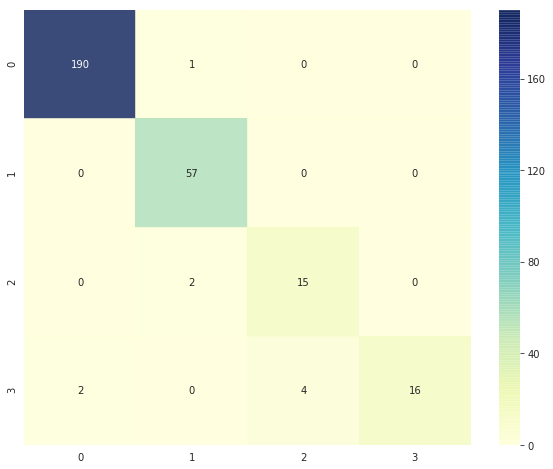

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print(classification_report([np.argmax(i) for i in Y_test], np.round(pred)))
fig = plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(confusion_matrix([np.argmax(i) for i in Y_test], np.round(pred) )),
            annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)
plt.show()

This is a very good validation accuracy! If we have a look and compare the class assignment predictions on the test data set with the true Y_test labels we conclude that they look quite similar and result in similar 4-class Categorical / Multinomial distributions:

In [45]:
print(list(np.round(pred)))

[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 3.0, 0.0, 1.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 3.0, 0.0, 3.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0,

In [46]:
print(list(np.where(Y_test)[1]))

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 0, 3, 0, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 3, 2, 0, 1, 0, 1, 0, 0, 1, 3, 1, 3, 1, 3, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 3, 0, 0, 0, 1, 3, 0, 3, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 2, 2, 1, 0, 3, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 3, 0, 0, 0, 2, 0, 1, 0, 0, 0, 3, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 3, 0, 1, 0, 0, 0, 3, 3, 0, 0, 0, 1]


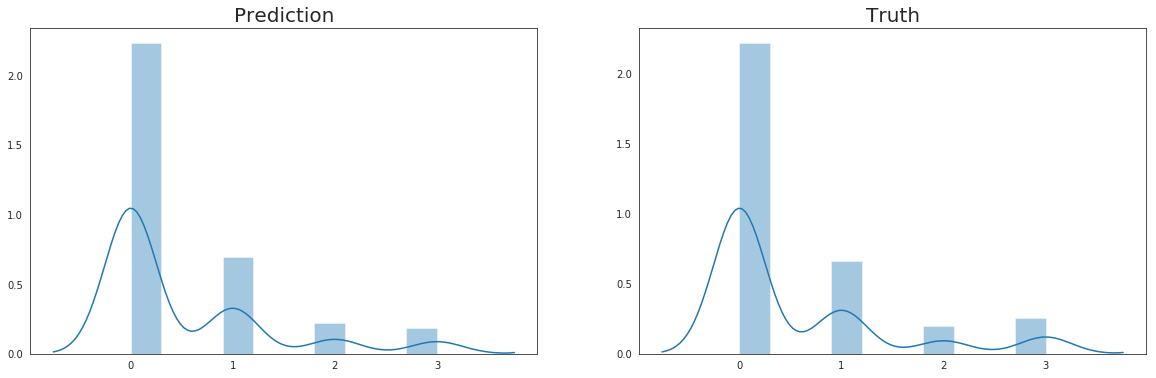

In [47]:
import seaborn as sns
fig = plt.figure(figsize=(20, 6))
plt.subplot(121)
sns.distplot(list(np.round(pred)))
plt.title('Prediction', fontsize = 20)
plt.subplot(122)
sns.distplot(np.where(Y_test)[1])
plt.title('Truth', fontsize = 20)
plt.show()

Now comes the most interesting part of analysis. Let us calculate compute and display the tSNE plot together with decision boundaries, the way we did for the Maximum Likelihood Neural Network with TensorFlow in the previous section. For this purpose we again create a 100 x 100 grid and run the model prediction on each point of the grid:

In [48]:
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
my_grid_values = np.c_[xx.ravel(), yy.ravel()]

The grid points are our new X variable, we will also create a dummy Y variable which we will feed to PPC. The Y variable (labels) is dummy because we actually have already trained our Bayesian Neural Network using X_train, so now we only need an X variable (input data) but not the labels to evaluate the model on the grid using Posterior Predictive Check (PPC) procedure. The labels will be calculated / predicted by the model. However we can run PPC in PyMC3 only using a model as a context, an the model has 2 input variables X and Y, this implies we need to feed some dummy variable Y just to follow the model syntax. It is important that the dimensions of the dummy variable are identical to Y_test and Y_train. Therefore, we pretend that all 10201 points on the grid belong to the class label 1 (out of class labels 0, 1, 2, 3), i.e. use [0,1,0,0] as an array of probabilities to belong to a certain class.

In [49]:
dummy_out = np.array([[0,1,0,0]]*10201)
dummy_out.shape

(10201, 4)

Now we are going to run the Posterior Predictive Checks (PPCs) a number of times for each point ion the 100 x 100 grid in order to get a mean and an uncertainty estimates for each point of the grid. Since PPCs returns a label of assignment to each class on each grid point, we need to recalculate the labels into probabilities of observing each of the 4 labels.

In [50]:
Z_prob_list = []
for k in range(10):
    X.set_value(np.float32(my_grid_values))
    Y.set_value(np.float32(dummy_out))
    model = build_bayesian_neural_network(X, Y)
    ppc = pm.sample_posterior_predictive(trace, model = model, samples = 500, progressbar = False)
    if (k + 1) % 10 == 0:
            print('Finished {} posterior predictive checks'.format(k + 1))
    
    my_probs = []
    for j in range(ppc['likelihood'].shape[1]):
        my_probs.append([sum(np.array([i[j] for i in ppc['likelihood']]) == 0) / ppc['likelihood'].shape[0],
                         sum(np.array([i[j] for i in ppc['likelihood']]) == 1) / ppc['likelihood'].shape[0],
                         sum(np.array([i[j] for i in ppc['likelihood']]) == 2) / ppc['likelihood'].shape[0],
                         sum(np.array([i[j] for i in ppc['likelihood']]) == 3) / ppc['likelihood'].shape[0]])
    Z_prob = np.array([np.max(i) for i in np.array(my_probs)])
    Z_prob_list.append(Z_prob)

Finished 10 posterior predictive checks


Nex we calculate the mean and the standard deviation for probability of assigning each point of the grid to one of the 4 classes of cells, and visualize the mean probability and uncertainty:

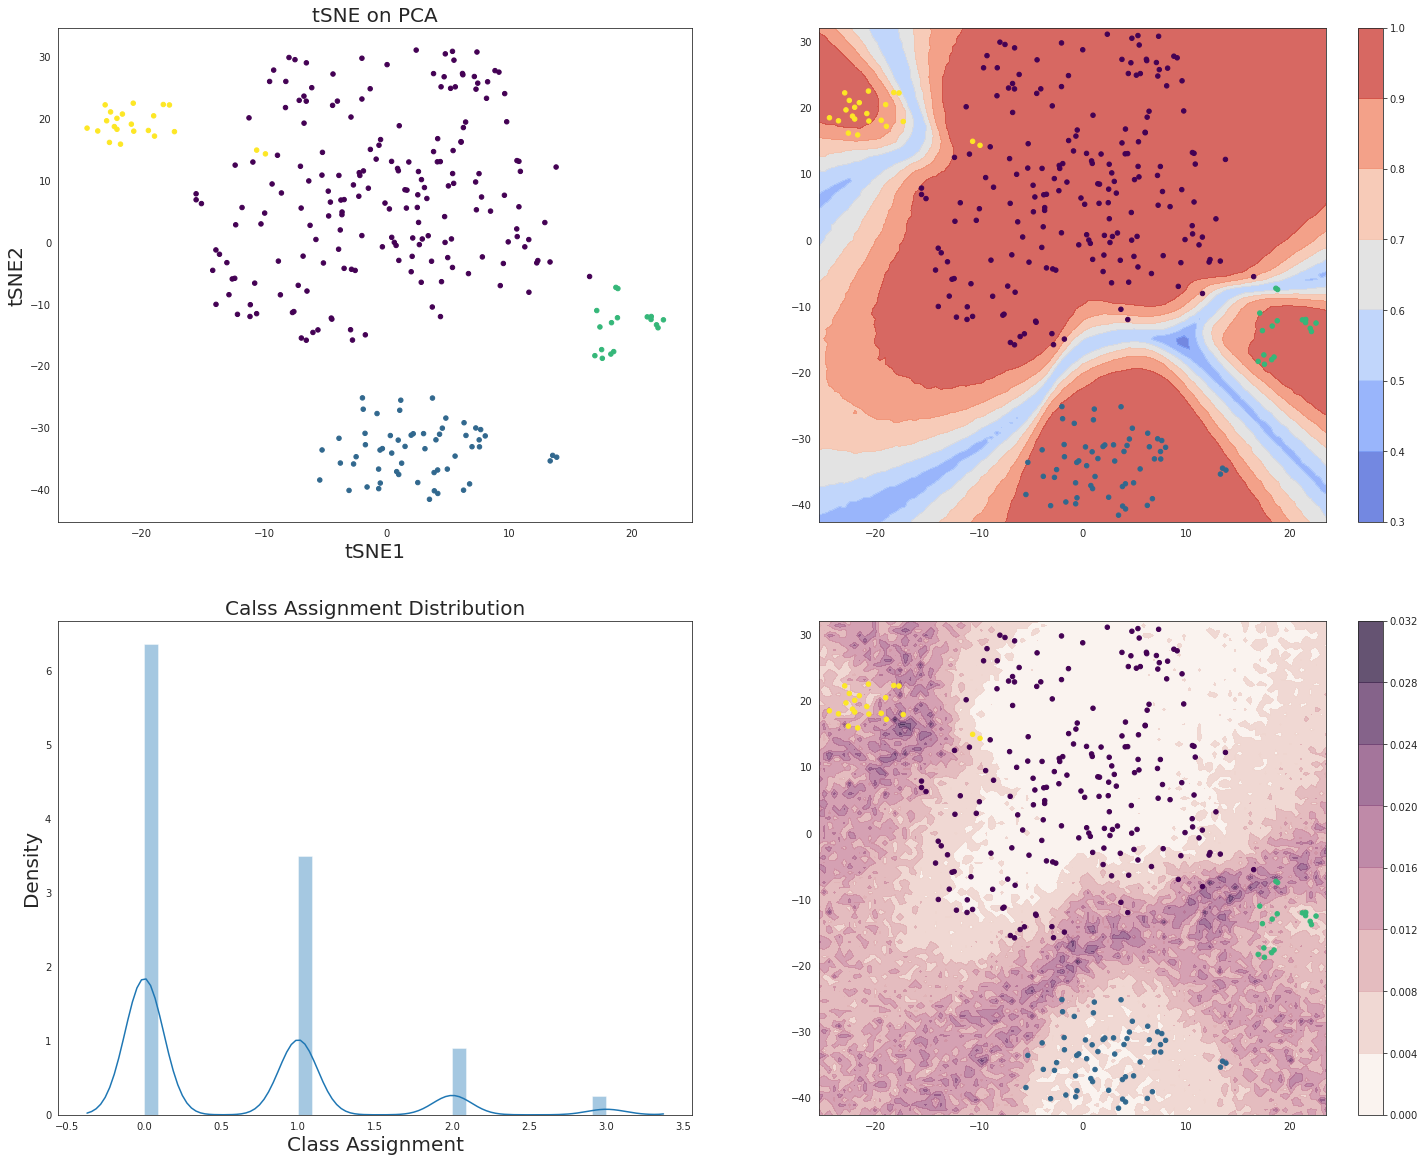

In [51]:
Z_prob_mean = np.array(Z_prob_list).mean(axis=0)
Z_prob_mean = Z_prob_mean.reshape(xx.shape)
Z_prob_std = np.array(Z_prob_list).std(axis=0)
Z_prob_std = Z_prob_std.reshape(xx.shape)
Z_prob_std

fig = plt.figure(figsize=(25, 20))
plt.subplot(221)
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.title('tSNE on PCA', fontsize = 20)
plt.xlabel("tSNE1", fontsize = 20)
plt.ylabel("tSNE2", fontsize = 20)

plt.subplot(222)
plt.contourf(xx, yy, Z_prob_mean, cmap = plt.cm.coolwarm, alpha = 0.8)
plt.colorbar()
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.subplot(223)
sns.distplot(np.round(ppc['likelihood'].mean(axis=0)))
plt.title('Calss Assignment Distribution', fontsize = 20)
plt.xlabel("Class Assignment", fontsize = 20)
plt.ylabel("Density", fontsize = 20)

plt.subplot(224)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.contourf(xx, yy, Z_prob_std, cmap = cmap, alpha = 0.8)
plt.colorbar()
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

We can see that the region between the purple and the yeallow cluster demonstrates especially high uncertainty of assignment of a cell from that region to either cluster. The same but less pronounced effect is visible for the boundary between the purple and the green cluster. Thus for each cell from the hold-out test data set we have a probability of assignment to a cluster and a measure of how uncertain is this probability.

In [52]:
pd.DataFrame({'Cluster': np.round(ppc['likelihood'].mean(axis=0)),
              'Probability': np.array(Z_prob_list).mean(axis=0),
             'Uncertanty': np.array(Z_prob_list).std(axis=0)}).sample(frac=1).iloc[0:10,0:3]

Cluster  Probability  Uncertanty
3085      1.0       0.8726    0.010993
1323      1.0       0.6822    0.014323
8908      1.0       0.6954    0.011280
5782      0.0       0.9724    0.007365
8311      0.0       0.9808    0.007277
6091      0.0       0.9884    0.003878
7059      0.0       0.9732    0.004750
9005      2.0       0.5530    0.014401
1288      1.0       0.9718    0.009978
7255      0.0       0.9846    0.006135

### How to cope with data unseen during training? <a class="anchor" id="How to cope with data unseen during training?"></a>
In this section we will apply Bayesian Neural Netrwok created in Edward to a classifiaction problem, namely we will try the model to recognize subtypes of Cancer Associated Fibroblasts (CAFs) from the scRNAseq project of Kristian Pietras from Lund University. Later we will include fibroblasts from another scRNAseq data set, Colorectal Cancer (CRC) which comes from different technology and different organism and non-fibroblast cells from CRC and demonstrate the model's higher uncertanty in assigning non-fibroblast cells to one of the CAF clusters. Let us start with reading CAFs, CRC fibroblast and CRC non-fibroblast scRNAseq data, we specifically selected only common genes for all the 3 data sets:

In [53]:
import pandas as pd
cafs = pd.read_csv('/home/nikolay/WABI/K_Pietras/CRC/CAFs_XGBoost.txt',sep='\t')
crc_fibro = pd.read_csv('/home/nikolay/WABI/K_Pietras/CRC/CRC_FIBRO_RF.txt',sep='\t')
crc_all_cells_minus_fibro = pd.read_csv('/home/nikolay/WABI/K_Pietras/CRC/CRC_ALL_CELLS_MINUS_FIBRO_RF.txt',sep='\t')
print('CAFs data set has dimensions: {}'.format(cafs.shape))
print('CRC fibroblast data set has dimensions: {}'.format(crc_fibro.shape))
print('CRC other cells data set has dimensions: {}'.format(crc_all_cells_minus_fibro.shape))

CAFs data set has dimensions: (716, 9202)
CRC fibroblast data set has dimensions: (17, 9201)
CRC other cells data set has dimensions: (347, 9201)


In [54]:
cafs.iloc[0:5,0:10]

TRAPPC2   KIAA0141   KIAA1841   C17orf49  NCBP2.AS2  \
SS2_15_0048_A3   0.000000   0.000000   0.000000   0.000000   0.000000   
SS2_15_0048_A6   0.000000   0.000000   0.000000  19.807819   0.000000   
SS2_15_0048_A5   0.000000   2.190080   0.000000   0.000000   0.000000   
SS2_15_0048_A4   0.000000   3.314831  19.843349  28.724288  76.155489   
SS2_15_0048_A1  33.807347  87.979006   0.000000   0.000000   0.000000   

                 C2orf68    C1orf123   C21orf59    C11orf58  TGIF2.C20orf24  
SS2_15_0048_A3  0.000000    0.000000   0.000000   11.292250        0.000000  
SS2_15_0048_A6  0.000000    0.000000   0.000000  132.429416        0.000000  
SS2_15_0048_A5  0.000000    0.000000  76.368453    0.000000       55.859441  
SS2_15_0048_A4  1.611635  110.748706   0.000000   69.348639        0.000000  
SS2_15_0048_A1  0.000000   12.996538  31.776145   86.389846       63.388776

We can see that the CRC fibroblast data set contains 17 cells. Therefore we will randonly select 17 CAFs cells as a hold-out test data set, and keep the rest cells for training the classifier:

In [55]:
import numpy as np
np.random.seed(1)
samples_to_select = list(np.random.choice(list(cafs.index), 17, replace=False))
samples_to_keep = [i for i in list(cafs.index) if i not in samples_to_select]
print('We will randomply select {} samples'.format(len(samples_to_select)))
print('And keep the rest {} samples'.format(len(samples_to_keep)))
cafs_test = cafs.loc[samples_to_select,:]
X_cafs_test = cafs_test.values[:,0:(cafs.shape[1]-1)]
Y_cafs_test = cafs_test.values[:,cafs.shape[1]-1]
cafs_train = cafs.loc[samples_to_keep,:]
X_cafs_train = cafs_train.values[:,0:(cafs.shape[1]-1)]
Y_cafs_train = cafs_train.values[:,cafs.shape[1]-1]

We will randomply select 17 samples
And keep the rest 699 samples


Let us also randomly select 17 cells other than fibroblasts from the Colorectal Cancer (CRC) data set. We will use them for comparision of the classification results with the 17 fibroblasts from the the same data set using the Bayesian Neural Network trained on the CAFs data set. The hypothesis is that fibroblasts from the CRC data set will have a higher uncertainty of prediction compared to the native 17 test CAFs, and the non-fibroblast cells from the CRC data set will have even higher uncertanty of classification, i.e. the model will say "I do not know how to classify those 17 non-fibroblast cells because I was trained on fibroblasts only".

In [56]:
nonfibro_samples_to_select = list(np.random.choice(list(crc_all_cells_minus_fibro.index), 17, replace=False))
crc_all_cells_minus_fibro = crc_all_cells_minus_fibro.loc[nonfibro_samples_to_select,:]
crc_fibro = crc_fibro.values
crc_all_cells_minus_fibro = crc_all_cells_minus_fibro.values
nonfibro_samples_to_select

['RHL2718__Epithelial__#2749FE',
 'RHC3641__Epithelial__#2749FE',
 'RHC4935__Epithelial__#2749FE',
 'RHC3898__Epithelial__#2749FE',
 'RHC3907__Macrophage__#FFFF55',
 'RHC5613__Epithelial__#2749FE',
 'RHC3844__Epithelial__#2749FE',
 'RHL2749__Epithelial__#2749FE',
 'RHC4897__Bcell__#7DEA7B',
 'RHL2779__Epithelial__#2749FE',
 'RHL2780__Epithelial__#2749FE',
 'RHC5586__Epithelial__#2749FE',
 'RHC4130__Epithelial__#2749FE',
 'RHC4045__MastCell__#E596C5',
 'RHC3596__Bcell__#7DEA7B',
 'RHC3640__Epithelial__#2749FE',
 'RHC4050__Epithelial__#2749FE']

Now X_cafs_test, crc_fibro and crc_all_cells_minus_fibro should have 17 cells each. We will also one-hot encode the labels of the train and test CAFs data sets and keep the original label codes in Y_cafs_train_original and Y_cafs_test_original:

In [57]:
from sklearn.preprocessing import label_binarize
Y_cafs_train_original = Y_cafs_train
Y_cafs_train = label_binarize(Y_cafs_train, classes = [0, 1, 2, 3])
Y_cafs_test_original = Y_cafs_test
Y_cafs_test = label_binarize(Y_cafs_test, classes = [0, 1, 2, 3])

print('CAFs test data set has dimensions: {}'.format(X_cafs_test.shape))
print('CRC fibroblast data set has dimensions: {}'.format(crc_fibro.shape))
print('CRC other cells data set has dimensions: {}'.format(crc_all_cells_minus_fibro.shape))

CAFs test data set has dimensions: (17, 9201)
CRC fibroblast data set has dimensions: (17, 9201)
CRC other cells data set has dimensions: (17, 9201)


Now let us make our Variational Inference model of Bayesian Neural Network in Edward:

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd

n_samples = X_cafs_train.shape[0]      # number of samples
n_input = X_cafs_train.shape[1]        # number of input neurons (features)
n_classes = Y_cafs_train.shape[1]      # number of classes
n_hidden = 64                          # number of hidden neurons

# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [n_samples, n_input])
y = tf.placeholder(tf.float32, [n_samples, n_classes])

# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w_hidden = Normal(loc = tf.zeros([n_input, n_hidden]), scale = tf.ones([n_input, n_hidden]))
w_output = Normal(loc = tf.zeros([n_hidden, n_classes]), scale = tf.ones([n_hidden, n_classes]))
b_hidden = Normal(loc = tf.zeros(n_hidden), scale = tf.ones(n_hidden))
b_output = Normal(loc = tf.zeros(n_classes), scale = tf.ones(n_classes))

# Categorical likelihood for classication.
y = Categorical(tf.matmul(tf.tanh(tf.matmul(x, w_hidden) + b_hidden), w_output) + b_output)

# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw_hidden = Normal(loc=tf.Variable(tf.random_normal([n_input, n_hidden])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_input, n_hidden]))))
qb_hidden = Normal(loc=tf.Variable(tf.random_normal([n_hidden])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_hidden]))))
qw_output = Normal(loc=tf.Variable(tf.random_normal([n_hidden, n_classes])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_hidden, n_classes]))))
qb_output = Normal(loc=tf.Variable(tf.random_normal([n_classes])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_classes]))))

inference = ed.KLqp({w_hidden: qw_hidden, b_hidden: qb_hidden, w_output: qw_output, b_output: qb_output}, 
                    data={x: X_cafs_train, y: Y_cafs_train_original})
inference.run(n_iter = 10000) #n_samples = 20

10000/10000 [100%] ██████████████████████████████ Elapsed: 1069s | Loss: 1224.727


Now, once we have computed an approximation to the true Posterior, we can draw samples from the approximation and use them to predict the probabilities of class assignment for 17 CAFs hold-out test cells, 17 CRC fibroblasts and CRC non-fibroblast cells:

In [60]:
# Generate samples from the posterior and store them.
n_samples = 1000

prob_cafs_test_list = []
prob_crc_fibro_list = []
prob_crc_all_cells_minus_fibro_list = []

w_hidden_samples = []
b_hidden_samples = []
w_output_samples = []
b_output_samples = []
for i in range(n_samples):
    # Sample from the posterior of fitting parameters of Bayesian Neural Network
    w_hidden_samp = qw_hidden.sample()
    b_hidden_samp = qb_hidden.sample()
    w_output_samp = qw_output.sample()
    b_output_samp = qb_output.sample()
    
    # Store samples from the posterior of fitting parameters of Bayesian Neural Network
    w_hidden_samples.append(w_hidden_samp)
    b_hidden_samples.append(b_hidden_samp)
    w_output_samples.append(w_output_samp)
    b_output_samples.append(b_output_samp)
    
    # Compute the probabiliy of each class for each sample for CAFs test data set, CRC fibro- and non-fibroblast cells
    prob_cafs_test_list.append(tf.nn.softmax(tf.matmul(tf.tanh(tf.matmul(np.float32(X_cafs_test), w_hidden_samp) 
                                                               + b_hidden_samp), w_output_samp) + b_output_samp).eval())
    prob_crc_fibro_list.append(tf.nn.softmax(tf.matmul(tf.tanh(tf.matmul(np.float32(crc_fibro), w_hidden_samp) 
                                                               + b_hidden_samp), w_output_samp) + b_output_samp).eval())
    prob_crc_all_cells_minus_fibro_list.append(
        tf.nn.softmax(tf.matmul(tf.tanh(tf.matmul(np.float32(crc_all_cells_minus_fibro), w_hidden_samp) 
                                        + b_hidden_samp), w_output_samp) + b_output_samp).eval())
    if (i + 1) % 100 == 0:
        print('Finished drawing {} samples'.format(i + 1))

Finished drawing 100 samples
Finished drawing 200 samples
Finished drawing 300 samples
Finished drawing 400 samples
Finished drawing 500 samples
Finished drawing 600 samples
Finished drawing 700 samples
Finished drawing 800 samples
Finished drawing 900 samples
Finished drawing 1000 samples


Let us calculate thhe accuracy of prediction for the CAFs hold-out test data set:

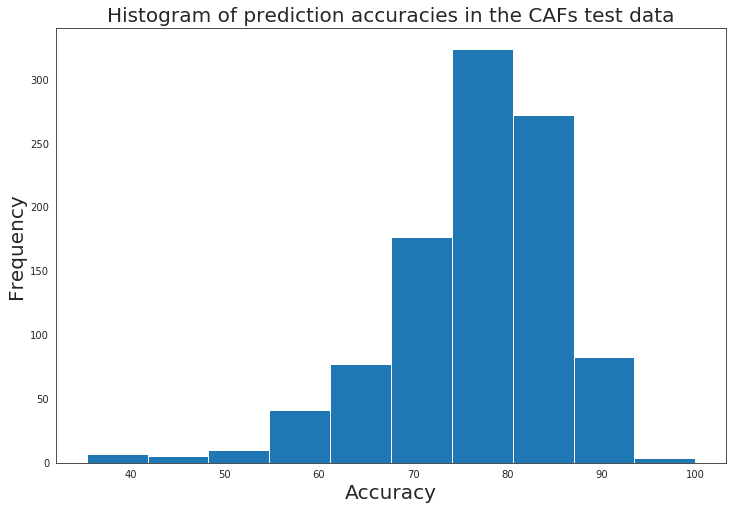

In [61]:
accuracy_list = []
for prob in prob_cafs_test_list:
    pred = np.argmax(prob, axis = 1).astype(np.float32)
    accuracy_list.append((pred == np.where(Y_cafs_test)[1]).mean()*100)
    
fig = plt.figure(figsize = (12, 8))
plt.hist(accuracy_list, bins = 10)
plt.title("Histogram of prediction accuracies in the CAFs test data", fontsize = 20)
plt.xlabel("Accuracy", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.show()

In [62]:
print('Accuracy = {0} +/- {1}%'.format(np.round(np.mean(np.array(accuracy_list)), 2), 
                                       np.round(np.std(np.array(accuracy_list)), 2)))

Accuracy = 75.8 +/- 8.48%


Finally, we will plot probability and uncertainty values for CAFs test, CRC fibroblasts and CRC non-fibroblats (all the three have 17 cells each) as box-plots and check how significant is the difference between the values:

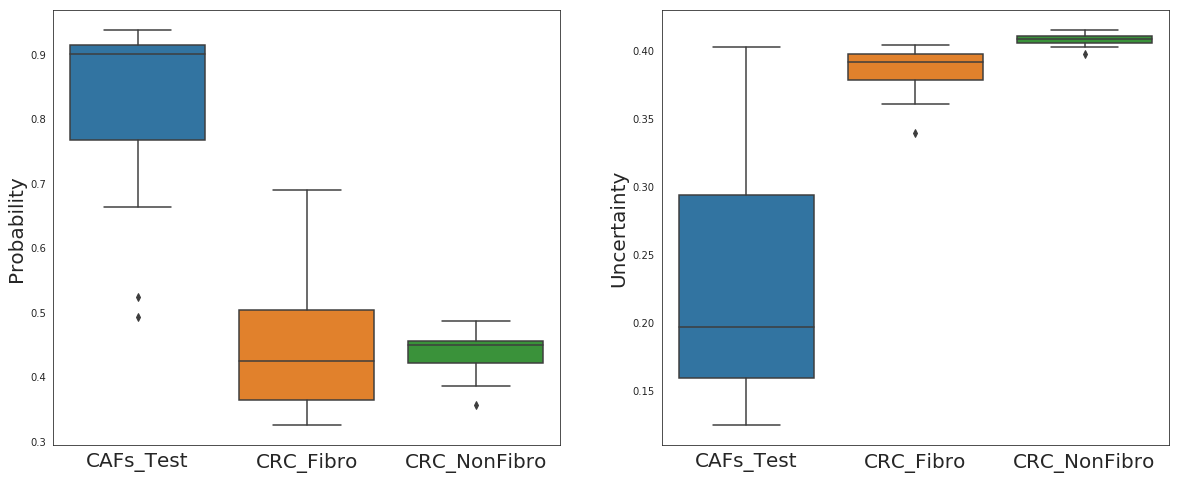

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(20, 8))
#plt.title('Comparison', fontsize = 20)

ax = fig.add_subplot(121)
sns.boxplot(data=[[np.max(i) for i in np.array(prob_cafs_test_list).mean(axis=0)], 
                  [np.max(i) for i in np.array(prob_crc_fibro_list).mean(axis=0)], 
                  [np.max(i) for i in np.array(prob_crc_all_cells_minus_fibro_list).mean(axis=0)]], palette = 'tab10')
plt.ylabel('Probability',fontsize=20)
ax.set_xticklabels(['CAFs_Test','CRC_Fibro','CRC_NonFibro'], fontsize = 20)

ax = fig.add_subplot(122)
sns.boxplot(data=[[np.max(i) for i in np.array(prob_cafs_test_list).std(axis=0)], 
                  [np.max(i) for i in np.array(prob_crc_fibro_list).std(axis=0)], 
                  [np.max(i) for i in np.array(prob_crc_all_cells_minus_fibro_list).std(axis=0)]],
            palette = 'tab10')
plt.ylabel('Uncertainty',fontsize=20)
ax.set_xticklabels(['CAFs_Test','CRC_Fibro','CRC_NonFibro'], fontsize = 20)

plt.show()

In [64]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu([np.max(i) for i in np.array(prob_crc_fibro_list).mean(axis=0)], 
                       [np.max(i) for i in np.array(prob_crc_all_cells_minus_fibro_list).mean(axis=0)])
print('Statistics = %.3f, p = %.3f' % (stat, p))

Statistics = 123.000, p = 0.235


In [65]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu([np.max(i) for i in np.array(prob_crc_fibro_list).std(axis=0)], 
                       [np.max(i) for i in np.array(prob_crc_all_cells_minus_fibro_list).std(axis=0)])
print('Statistics = %.3f, p = %.10f' % (stat, p))

Statistics = 8.000, p = 0.0000014045


We conclude that the model was significantly higher uncertainty about classification of CRC non-fibroblast compared to CRC fibroblasts cells. This high uncertainty can be a strong indication that the model encountered data which it did not experience during training. In this case, more information / data is needed for the model to make a decision. This can be particularly important if this decision concerns individual's safty such as in health care or self-driving cars.

### Making your own MCMC sampler <a class="anchor" id="Making your own MCMC sampler"></a>
In this section we will try to implement some simple MCMC sampler using just Python code. Then we use the sampler to draw samples from a Posterior distribution and compare the results with the Posterior obtained by PyMC3. We will start with loading Python modules and building a toy data set. The toy data set is just a few points drawn from the Normal distribution, let us check how it looks like by plotting the corresponding histogram:

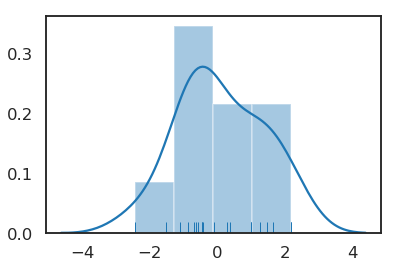

In [11]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

data = np.random.normal(size=20)
sns.distplot(data, rug = True)
plt.show()

Now let us define the model. We assume the Likelihood of observing the data x has Normal distributions with two parameters $\mu$ and $\sigma$, i.e. it has the form $L(x | \mu,\sigma)$. Let us assume that in the scaled case $\sigma = 1$, the Likelihood is $L(x|μ,\sigma) ∼ Normal(x | μ,1)$. Now we have to put a Prior distribution on the mean value $\mu$, we will assume that it follows a Normal distribution as well with mean = 0 and standard deviation = 1, thus our model is given by:

$$
\rm{L}(x|μ,\sigma) ∼ Normal(x | μ,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\prod_{i=1} \exp{\left\{-\frac{(x_i-\mu)^2}{2\sigma^2}\right\}} \\
\rm{Prior}(μ) ∼ Normal(\xi,\tau) = \frac{1}{\sqrt{2\pi\tau^2}}\exp{\left\{-\frac{(\mu-\xi)^2}{2\tau^2}\right\}}
$$

Since we used a conjugate Prior, we can compute the integral in the Bayes formula analytically, [derivation is here](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM). The final Posterior distribution will follow Normal distribution:

$$
\rm{Posterior}(μ|x) ∼ Normal(\rm{M},\Sigma) = \frac{1}{\sqrt{2\pi\Sigma^2}}\exp{\left\{-\frac{(\mu-\rm{M})^2}{2\Sigma^2}\right\}} \\
M = \frac{\displaystyle\tau^2N\bar{x}+\sigma^2\xi}{\displaystyle\tau^2N+\sigma^2} \\
\Sigma^2 = \frac{\displaystyle\sigma^2\tau^2}{\displaystyle\tau^2N+\sigma^2}
$$

So here we will define a function which uses the result of analytical Posterior calculation:

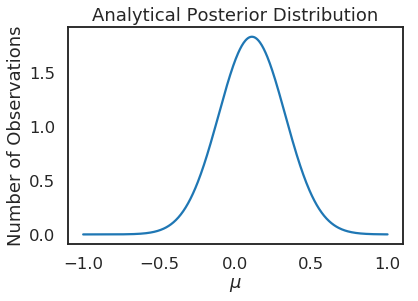

In [12]:
def analytical_posterior(mu, data, xi, tau, sigma):
    N = len(data)
    x_bar = (1/N)*(np.sum(data))
    M = (x_bar*N*tau**2 + xi*sigma**2) / (N*tau**2 + sigma**2)
    Sigma = np.sqrt(((sigma**2)*(tau**2)) / (N*tau**2 + sigma**2))
    return sp.stats.norm(M, Sigma).pdf(mu)

mu = np.linspace(-1, 1, 500)
plt.plot(mu, analytical_posterior(mu, data, 0, 1, 1))
plt.xlabel('$\mu$')
plt.ylabel('Number of Observations')
plt.title('Analytical Posterior Distribution')
plt.show()

Now let us implement our own Metropolis sampler and sample from the Posterior and compare the results with the analytically derived Posterior:

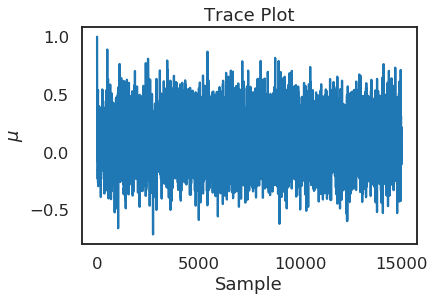

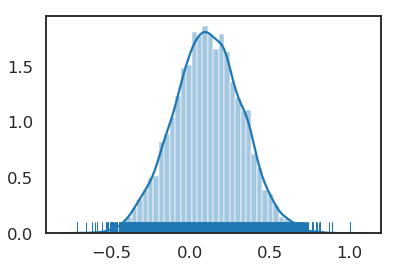

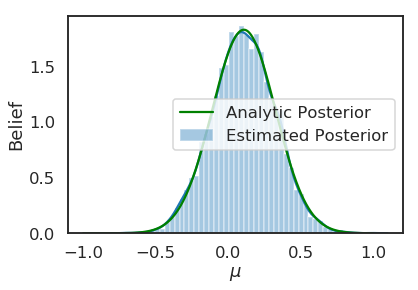

In [13]:
def Metropolis_Sampler(data, mu_init = 1, n_samples = 10):
    mu_current = mu_init
    posterior_sample = [mu_current]
    for i in range(n_samples):
        mu_next = sp.stats.norm(mu_current, 0.5).rvs()
        
        prior_current = sp.stats.norm(0, 1).pdf(mu_current)
        prior_next = sp.stats.norm(0, 1).pdf(mu_next)
        
        likelihood_current = sp.stats.norm(mu_current, 1).pdf(data).prod()
        likelihood_next = sp.stats.norm(mu_next, 1).pdf(data).prod()
        
        posterior_current = likelihood_current*prior_current
        posterior_next = likelihood_next*prior_next
        
        posterior_accept = posterior_next / posterior_current
        if  posterior_accept > np.random.rand():
            mu_current = mu_next
        
        posterior_sample.append(mu_current)
    return posterior_sample

posterior_samples = Metropolis_Sampler(data, 1, 15000)

plt.plot(posterior_samples)
plt.xlabel('Sample')
plt.ylabel('$\mu$')
plt.title('Trace Plot')
plt.show()

sns.distplot(posterior_samples, rug = True)
plt.show()

ax = plt.subplot()

sns.distplot(posterior_samples, ax=ax, label='Estimated Posterior')
x = np.linspace(-1, 1, 500)
ax.plot(x, analytical_posterior(x, data, 0, 1, 1), 'g', label='Analytic Posterior')
_ = ax.set(xlabel='$\mu$', ylabel='Belief');
ax.legend();
plt.show()

Now let us use PyMC3 and compare sampling done by PyMC3 with the hand-written Metropolis sampler and the analytical Posterior distributions:

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 31000/31000 [00:04<00:00, 7217.23draws/s]
The number of effective samples is smaller than 25% for some parameters.


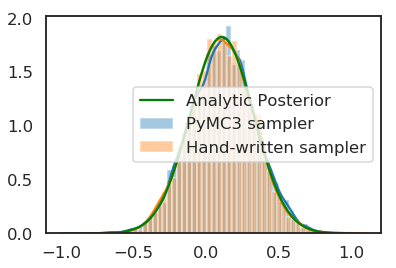

In [14]:
import pymc3 as pm
with pm.Model():
    mu = pm.Normal('mu', 0 ,1)
    sigma = 1
    posterior = pm.Normal('posterior', mu=mu, sd=sigma, observed=data)
    trace = pm.sample(15000, pm.Metropolis())

ax = plt.subplot()
sns.distplot(trace['mu'], label='PyMC3 sampler');
sns.distplot(posterior_samples, label='Hand-written sampler');
ax.plot(x, analytical_posterior(x, data, 0, 1, 1), 'g', label='Analytic Posterior')
ax.legend();

We conclude that analytical Posterior, hand-written Metropolis sampler and PyMC3 sampler produce pretty much overlapping Posterior distributions.

### Fitting Non-Linear Curve with Gaussian Process <a class="anchor" id="Fitting Non-Linear Curve with Gaussian Process"></a>

A common applied statistics task involves building regression models to characterize non-linear relationships between variables. It is possible to fit such models by assuming a particular non-linear functional form, such as a sinusoidal, exponential, or polynomial function, to describe one variable’s response to the variation in another. Unless this relationship is obvious from the outset, however, it involves possibly extensive model selection procedures to ensure the most appropriate model is retained. Alternatively, a non-parametric approach can be adopted by defining a set of knots across the variable space and use a spline or kernel regression to describe arbitrary non-linear relationships. However, knot layout procedures are somewhat ad hoc and can also involve variable selection. A third alternative is to adopt a Bayesian non-parametric strategy, and directly model the unknown underlying function. For this, we can employ Gaussian process models.

Describing a Bayesian procedure as “non-parametric” is something of a misnomer. The first step in setting up a Bayesian model is specifying a full probability model for the problem at hand, assigning probability densities to each model variable. Thus, it is difficult to specify a full probability model without the use of probability functions, which are parametric! In fact, Bayesian non-parametric methods do not imply that there are no parameters, but rather that the number of parameters grows with the size of the dataset. Rather, Bayesian non-parametric models are infinitely parametric.

What if we chose to use Gaussian distributions to model our data?

$$
p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}
$$
There would not seem to be any gain in doing this, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from a multivariate normal distribution is also normal:
$$
p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
{\mu_x} \
{\mu_y} \
\end{array}
}\right], \left[{
\begin{array}{cc}
{\Sigma_x} & {\Sigma_{xy}} \\
{\Sigma_{xy}^T} & {\Sigma_y}
\end{array}
}\right]\right)
$$

$$
p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)
$$

Also, conditional distributions of a subset of the elements of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$
p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y),\Sigma_x-\Sigma{xy}\Sigma_y^{-1}\Sigma{xy}^T)
$$
A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, with any marginal subset having a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an infinite vector is as a function. When we write a function that takes continuous values as inputs, we are essentially implying an infinite vector that only returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian represented as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a distribution over functions. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean function and a covariance function:

$$
p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))
$$
It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed.

For example, one specification of a GP might be:

$$
m(x) =0 $$

$$k(x,x^{\prime}) = \theta_1\exp{\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)}
$$

Here, the covariance function is a squared exponential, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to one, while those that are far apart return values closer to zero. It may seem odd to simply adopt the zero function to represent the mean function of the Gaussian process — surely we can do better than that! It turns out that most of the learning in the GP involves the covariance function and its hyperparameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function, respectively, evaluated at those points.

In [15]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, DotProduct

scikit-learn offers a library of about a dozen covariance functions, which they call kernels, to choose from. A flexible choice to start with is the Matèrn covariance.

$$
k_{M}(x) = \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} x}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} x}{l}\right)
$$

where $\Gamma$ is the gamma function and $K$ is a modified Bessel function. The form of covariance matrices sampled from this function is governed by three parameters, each of which controls a property of the covariance.

* amplitude ($\sigma$) controls the scaling of the output along the y-axis. This parameter is just a scalar multiplier, and is therefore usually left out of implementations of the Matèrn function (i.e. set to one)

* lengthscale ($l$) complements the amplitude by scaling realizations on the x-axis. Larger values push points closer together along this axis.

* roughness ($\nu$) controls the sharpness of ridges in the covariance function, which ultimately affect the roughness (smoothness) of realizations.

Though in general all the parameters are non-negative real-valued, when $\nu = p + 1/2$ for integer-valued $p$, the function can be expressed partly as a polynomial function of order $p$ and generates realizations that are $p$-times differentiable, so values $\nu \in {3/2, 5/2}$ are most common.

A GP kernel can be specified as the sum of additive components in scikit-learn simply by using the sum operator, so we can include a Matèrn component (Matern), an amplitude factor (ConstantKernel), as well as an observation noise (WhiteKernel):

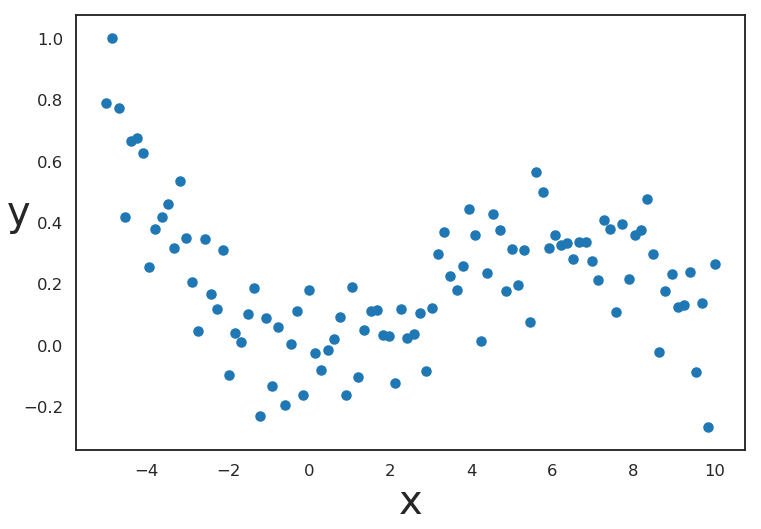

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)

N = 100
a = tf.placeholder("float")
b = tf.placeholder("float")
c = tf.placeholder("float")
d = tf.placeholder("float")
x = tf.linspace(-5.0, 10.0, num = N, name = "x")
noise = tf.random_normal(shape = [N,], mean = 0, stddev = 50.0, seed = 1)

# y = a*x^3 + b*x^2 + c*x +d 
with tf.Session() as sess:
    y = sess.run(tf.add(tf.add(tf.add(tf.add(tf.multiply(a,tf.pow(x,3)),tf.multiply(b,tf.pow(x, 2))),tf.multiply(c,x)),d),
                        noise), feed_dict= {a: -1, b: 10, c: 1, d: 1} )
    x = np.reshape(np.array(x.eval()), (N,1))
    y = np.reshape(np.array(y) / np.max(y), (N,1))

fig = plt.figure(figsize=(12, 8))
plt.scatter(x, y)
plt.xlabel("x",fontsize = 40)
plt.ylabel("y",fontsize = 40, rotation = 0)
plt.show()

In [19]:
kernel = Matern(length_scale = 1, nu = 3/2)
#kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
#kernel = ConstantKernel() + Matern(length_scale=1, nu=3/2) + WhiteKernel(noise_level=1)
gp = gaussian_process.GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 9, alpha=0.1)
#gp = gaussian_process.GaussianProcessRegressor()
gp.fit(x, y)

GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=1.5), n_restarts_optimizer=9,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [20]:
gp.kernel

Matern(length_scale=1, nu=1.5)

Along with the fit method, each supervised learning class retains a predict method that generates predicted outcomes ($y^{\ast}$) given a new set of predictors ($X^{\ast}$) distinct from those used to fit the model. For a Gaussian process, this is fulfulled by the posterior predictive distribution, which is the Gaussian process with the mean and covariance functions updated to their posterior forms, after having been fit.

$$
p(y^{\ast}|y, x, x^{\ast}) = \mathcal{GP}(m^{\ast}(x^{\ast}), k^{\ast}(x^{\ast}))
$$
where the posterior mean and covariance functions are calculated as:

$$
m^{\ast}(x^{\ast}) = k(x^{\ast},x)^T[k(x,x) + \sigma^2I]^{-1}y $$

$$ k^{\ast}(x^{\ast}) = k(x^{\ast},x^{\ast})+\sigma^2 – k(x^{\ast},x)^T[k(x,x) + \sigma^2I]^{-1}k(x^{\ast},x)
$$

[[ 0.66967496]
 [ 0.64625348]
 [ 0.62165754]
 [ 0.59599043]
 [ 0.56939692]]
[ 0.11880434  0.1101816   0.10241689  0.09556871  0.08966297]


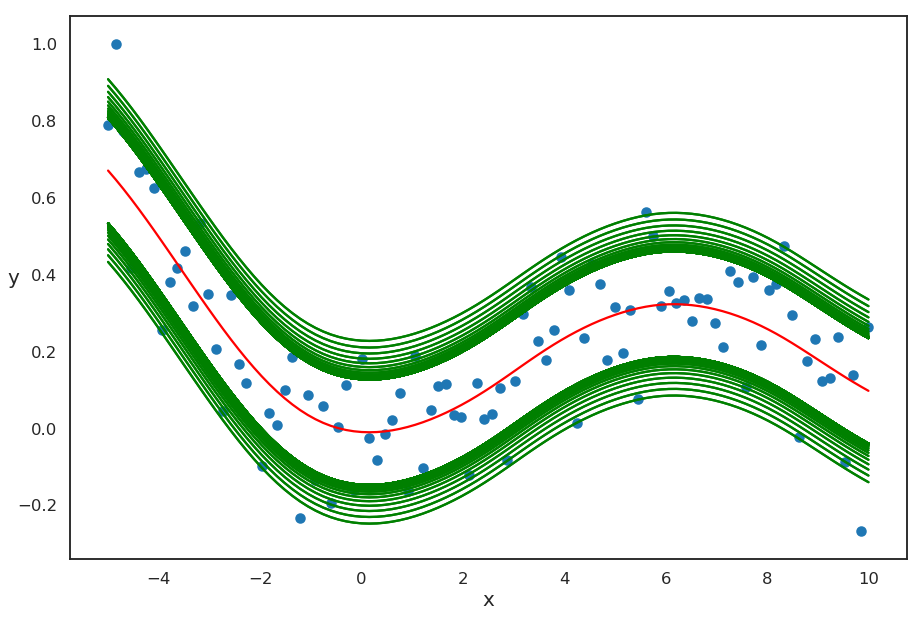

In [21]:
x_pred = np.linspace(-5, 10, num = 100).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)
print(y_pred[0:5])
print(sigma[0:5])

plt.scatter(x, y)
plt.plot(x_pred, y_pred, c='r')
plt.plot(x_pred, y_pred + 2*sigma, c='g')
plt.plot(x_pred, y_pred - 2*sigma, c='g')
plt.xlabel("x",fontsize = 20)
plt.ylabel("y",fontsize = 20, rotation = 0)
plt.show()